## Setup - imports, time, parameters, size function

In [1]:
runno = '7497'

In [2]:
from invisible_cities.database import load_db

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sys import getsizeof

In [4]:
import sys

def get_size(obj, seen=None,):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [5]:
from time import time as time
t0 = time()

In [6]:
# Fit functions

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

def gauss2(x, A, m, v): 
    if v <= 0:
        return 1e10
    return A*np.exp(-(x-m)**2 / (2*v))

def offset_gauss(x, A, m, v, C):
    return C + A*np.exp(-(x-m)**2 / (2*v))

def const(x, a):
    return a + 0*x

def line(x, m, b):
    return m*x + b

from scipy.optimize import curve_fit

def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

## HIGH STATISTICS COMBINED FILE READING

In [7]:
f = open('/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/meshed_outputs_20201222/meshed_output_allfiles_'+runno+'.json')
histat_data = json.load(f)
f.close()

In [8]:
histat_data.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres'])

In [9]:
len(histat_data['events_energy'])

683091

In [10]:
histat_events_energy_subtracted_pre = np.array(histat_data['events_energy']) - np.array(histat_data['events_prewindow_sums'])
histat_events_energy_subtracted_post = np.array(histat_data['events_energy']) - np.array(histat_data['events_postwindow_sums'])
histat_prepostavg = np.array(histat_data['events_postwindow_sums']) / 2 + np.array(histat_data['events_postwindow_sums']) / 2
histat_events_energy_subtracted_avg = np.array(histat_data['events_energy']) - histat_prepostavg

histat_Zgauss = np.array(histat_data['all_Zgauss'])
histat_Zrms = np.array(histat_data['all_Zrms'])
histatX, histatY = np.array(histat_data['events_X_sipm_subtracted']), np.array(histat_data['events_Y_sipm_subtracted'])
histatR2 = np.array(histat_data['all_R2'])
histatSRES = np.array(histat_data['all_sres'])
histatSSRES = np.array(histat_data['all_ssres'])

In [11]:
import itertools as it
zlims = [100, 200, 300, 400, 510]
rlims = [50, 100, 150, 180]
nomask = np.ones(len(histatR2), dtype='bool')

def get_bin_from_xy(x, y, emap, bounds):
    lowerx, lowery = bounds[0][0], bounds[1][0]
    upperx, uppery = bounds[0][1], bounds[1][1]
    nbinsx = len(emap)
    nbinsy = len(emap[0])
    dbinx = (bounds[0][1] - bounds[0][0]) / nbinsx
    dbiny = (bounds[1][1] - bounds[1][0]) / nbinsy
    ix = min(floor((x - lowerx) / dbinx), nbinsx-1)
    iy = min(floor((y - lowery) / dbiny), nbinsy-1)
    return ix, iy

def correct_energies(emap, bounds, umask = nomask, ltmap = None, show = True, xvals = histatX, yvals = histatY, energies = histat_events_energy_subtracted_pre, vocal = False):
    if vocal:
        print('Correcting energies...')
    ecorrs = []
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    tcorstart = time()
    masked_xvals, masked_yvals = xvals[umask & xymask], yvals[umask & xymask]
    masked_energies = energies[umask & xymask]
    ncorevents = len(masked_xvals)
    factor_default = emap[int(len(emap)/2)][int(len(emap)/2)]
    for e in range(ncorevents):
        if vocal and e % 100000 == 0:
            print(e, '/', len(xvals[umask & xymask]))
            if e > 0:
                print('Est remaining =', round((ncorevents - e)*(time() - tcorstart) / e, 1))
        x, y = masked_xvals[e], masked_yvals[e]
        ix, iy = get_bin_from_xy(x, y, emap, bounds)
        factor = emap[ix][iy]
        if factor == 0 or np.isnan(factor):
            factor = factor_default
        if ltmap is not None:
            ixlt, iylt = get_bin_from_xy(x, y, ltmap, bounds)
            lt = ltmap[ixlt][iylt]
            z = all_Zgauss[umask & xymask][e]
            ltcorr = np.exp(z / lt)
            factor /= ltcorr
        ecorr = masked_energies[e] / factor
        ecorrs.append(ecorr)
    if show:
        plt.hist(ecorrs)
        plt.show()
    return np.array(ecorrs)

def fit_res_vs_zr(energies, emap, bounds, umask = nomask, show = True, xvals = histatX, yvals = histatY, zvals = histat_Zgauss):
    res_vs_zr = {}
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals = xvals[umask & xymask], yvals[umask & xymask], zvals[umask & xymask]

    for zlim, rlim in it.product(zlims, rlims):
    
        fidmask = ((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        h = plt.hist(energies[fidmask], range=(0.85, 1.15), bins = 30)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), 1, np.std(energies[fidmask]))
        
        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)

        FWHM = 2.355 * popt[2]
        mean = popt[1]
        resolution = 100 * FWHM / mean

        res_vs_zr[zlim*1000+rlim] = resolution

        if zlim == zlims[0] and rlim == rlims[0] and show:
            print('Fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
            plt.plot(xdata, fitgauss)
            plt.title('Z < '+str(zlim)+'; R < '+str(rlim)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.show()
        else:
            plt.close()
    
    return res_vs_zr

def plot_res_vs_zr(res_vs_zr):
    for rlim in rlims:
        res_vs_z = [ res_vs_zr[1000*zlim + rlim] for zlim in zlims ]
        plt.plot(zlims, res_vs_z, 'o', label = 'rlim = '+str(rlim)+' mm')
    plt.legend()
    plt.xlabel('Z upper limit (mm)')
    plt.ylabel('Resolution (%)')
    plt.show()
    print('Innermost resolution = ', round(res_vs_zr[1000*zlims[0] + rlims[0]], 2), '%')
    print('Outermost resolution = ', round(res_vs_zr[1000*zlims[-1] + rlims[-1]], 2), '%')
    
import h5py

def load_maps_from_file(filename, show = True):
    f = h5py.File(filename, 'r')
    e0map = np.array(f['e0']['block0_values'])
    ltmap = np.array(f['lt']['block0_values'])
    # f['mapinfo']['index'][i] tells you what is stored is stored in f['mapinfo']['values'][i]
    bounds = ((f['mapinfo']['values'][0], f['mapinfo']['values'][1]), (f['mapinfo']['values'][2], f['mapinfo']['values'][3]))
    f.close()

    if show:
        plt.imshow(e0map, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('E0')
        plt.show()

        plt.imshow(ltmap, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('LT')
        plt.clim(5000, 10000)
        plt.show()
    
    return e0map, ltmap, bounds

## Determine the range of the peak

### R2, SRES, SSRES distributions

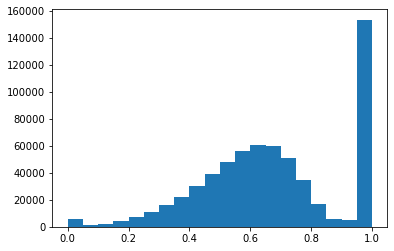

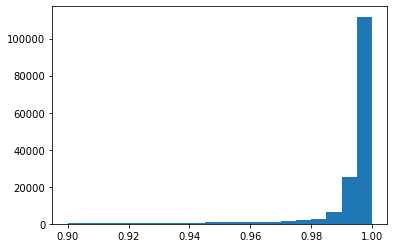

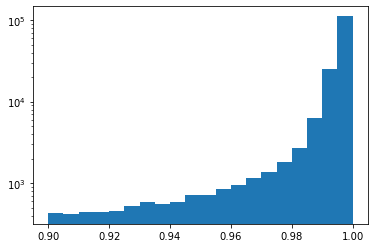

In [12]:
plt.hist(histatR2, range=(0, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.yscale('log')
plt.show()

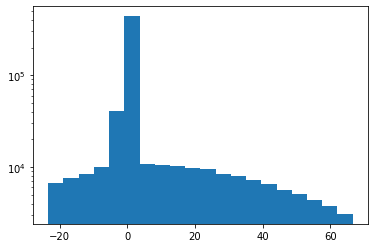

In [13]:
plt.hist(histatSRES, range=(np.percentile( histatSRES, 5), np.percentile( histatSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

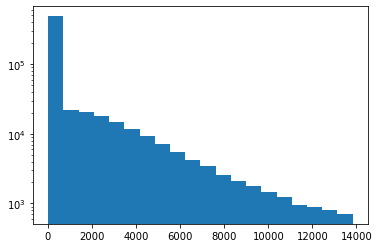

In [14]:
plt.hist(histatSSRES, range=(np.percentile( histatSSRES, 5), np.percentile( histatSSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

In [15]:
# Constant cuts
noise_bound = 0
zmax = 510
hienergybound = 2 # Events with double the median energy are excluded as possible Kr events

In [16]:
# Choose your analysis parameters:
# histat_events_energy_subtracted = histat_events_energy_subtracted_pre
# r2cut = 0.98
# histatZ = histat_Zgauss

## Check XYZ distributions

Peak range = 1252.0 , 4882.4
Selected percentage = 10.5 %


/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide


Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 18.7
200000 / 582890
Est remaining = 14.4
300000 / 582890
Est remaining = 10.7
400000 / 582890
Est remaining = 6.9
500000 / 582890
Est remaining = 3.5


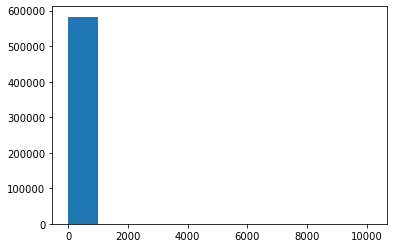

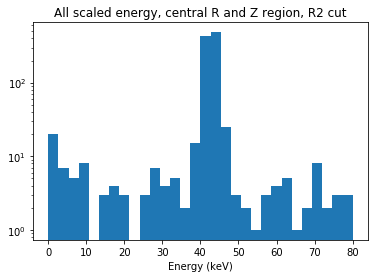

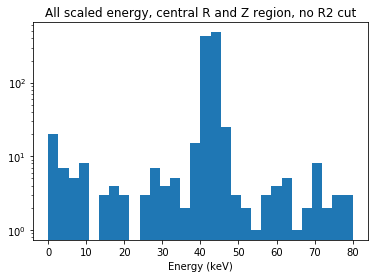

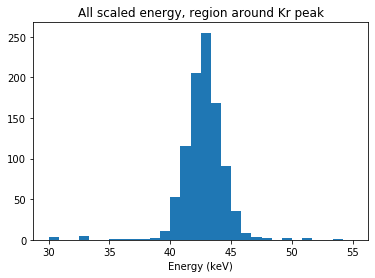

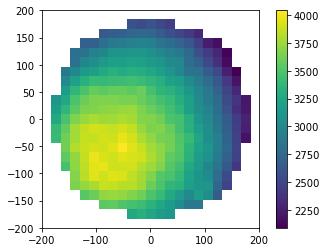

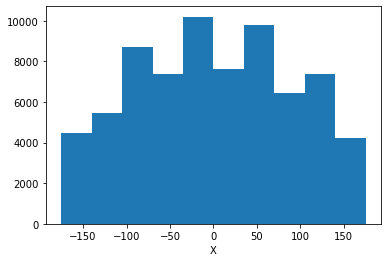

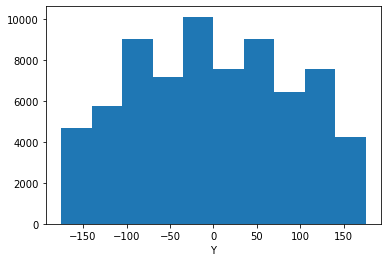

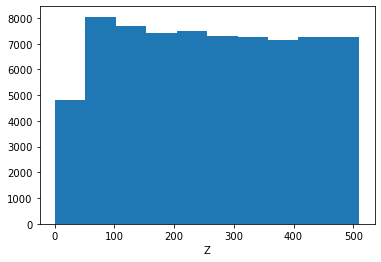

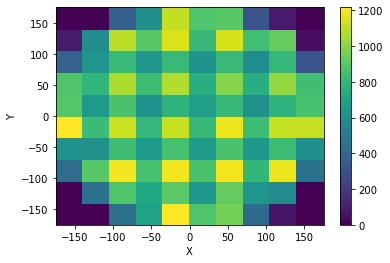

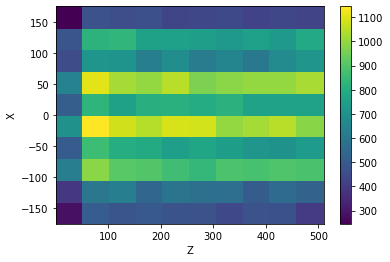

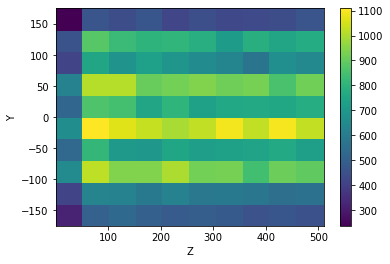

In [17]:
r2cut = 0.9
histatZ = histat_Zgauss
r2mask = histatR2 > r2cut
zmask = (histatZ > 0) & (histatZ < zmax)
rmask = histatX**2 + histatY**2 < 180**2
r2ZRnoisemask = r2mask & zmask & rmask # & (histat_events_energy_subtracted_pre > noise_bound)
hienergymask = histat_events_energy_subtracted_pre < hienergybound * np.percentile(histat_events_energy_subtracted_pre[r2ZRnoisemask], 50)
r2ZRhinoisemask = r2ZRnoisemask & hienergymask

med = np.median(histat_events_energy_subtracted_pre[r2ZRhinoisemask])
frac = 0.6827
lowcut = 0.5 - frac / 2
hicut = 0.5 + frac / 2
lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * lowcut))
rgt = med + 3 * (np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * hicut) - med)
print('Peak range =', round(lft,1),',', round(rgt,1))
histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted_pre > lft) & (histat_events_energy_subtracted_pre < rgt)
print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '%')

# Create own correction map
nbins = 23
clim = 200
dbin = 2 * clim / nbins
coord_range = np.linspace(-clim, clim, nbins + 1)
coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
events_sum = np.zeros((len(coord_bins),len(coord_bins)))
for ix in range(len(coord_bins)):
    for iy in range(len(coord_bins)):
        xbin = coord_bins[ix]
        ybin = coord_bins[iy]
        xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
        ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
        xymask = xmask & ymask
        events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
        energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted_pre[xymask & histat_selfmask])

energy_xy = energy_sum / events_sum
energy_xy_bounds = ((-200, 200), (-200, 200))

# Apply the correction
histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted_pre, xvals = histatX, yvals = histatY, vocal = True)
histat_all_scaled_energy *= 41.5



# Final cut spectra
histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, no R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
plt.title('All scaled energy, region around Kr peak')
plt.xlabel('Energy (keV)')
plt.show()


plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
plt.colorbar()
plt.show()


plt.hist(histatX[histat_selfmask])
plt.xlabel('X')
plt.show()

plt.hist(histatY[histat_selfmask])
plt.xlabel('Y')
plt.show()

plt.hist(histatZ[histat_selfmask])
plt.xlabel('Z')
plt.show()

h = plt.hist2d(histatX[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatX[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('X')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

In [18]:
def check_resolution(histatZ, histat_events_energy_subtracted, r2cut):

    # Create masks
    r2mask = histatR2 > r2cut
    zmask = (histatZ > 0) & (histatZ < zmax)
    rmask = histatX**2 + histatY**2 < 180**2
    r2ZRnoisemask = r2mask & (histat_events_energy_subtracted > noise_bound) & zmask & rmask
    hienergymask = histat_events_energy_subtracted < hienergybound * np.percentile(histat_events_energy_subtracted[r2ZRnoisemask], 50)
    r2ZRhinoisemask = r2ZRnoisemask & hienergymask

    # Set peak range
    med = np.median(histat_events_energy_subtracted[r2ZRhinoisemask])
    frac = 0.6827
    lowcut = 0.5 - frac / 2
    hicut = 0.5 + frac / 2
    lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * lowcut))
    rgt = med + 3 * (np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * hicut) - med)
    print('Peak range =', round(lft,1),',', round(rgt,1))
    histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted > lft) & (histat_events_energy_subtracted < rgt)
    print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '\%')
    
    # Plot spectra after applying various cuts
    plt.hist(histat_events_energy_subtracted, bins = 25)
    plt.yscale('log')
    plt.title('Full spectrum')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted, range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(lft, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[histat_selfmask], bins = 25)
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut; linear scale')
    plt.xlabel('Energy (pes)')
    plt.show()

    # Noise spectrum
    plt.hist(histat_events_energy_subtracted, range=(0, 500), bins = 25)
    plt.title('Noise spectrum')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_events_energy_subtracted[~r2mask], range=(0, 500), bins = 25)
    plt.title('Noise spectrum, bad R2')
    plt.yscale('log')
    plt.show()

    # Create own correction map
    nbins = 23
    clim = 200
    dbin = 2 * clim / nbins
    coord_range = np.linspace(-clim, clim, nbins + 1)
    coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

    energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
    events_sum = np.zeros((len(coord_bins),len(coord_bins)))
    for ix in range(len(coord_bins)):
        for iy in range(len(coord_bins)):
            xbin = coord_bins[ix]
            ybin = coord_bins[iy]
            xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
            ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
            xymask = xmask & ymask
            events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
            energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted[xymask & histat_selfmask])

    energy_xy = energy_sum / events_sum
    energy_xy_bounds = ((-200, 200), (-200, 200))

    plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    map_out = './maps_from_maxsipm/map_'+runno+'.npy'

    with open(map_out, 'wb') as f:
        np.save(f, energy_xy)

    with open(map_out, 'rb') as f:
        test_readin_xy = np.load(f)

    plt.imshow(test_readin_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    # Apply the correction
    histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
    histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)
    histat_all_scaled_energy *= 41.5

    plt.hist(histat_all_scaled_energy, range = (0, 80), bins = 20)
    plt.title('All scaled energy')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    # Final cut spectra
    histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, no R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
    plt.title('All scaled energy, region around Kr peak, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.show()

    # r7472_scaled_energy = correct_energies(e0_7472, bounds_7472, umask = selfmask, ltmap = lt_7472)
    # r7472_res_vs_zr = fit_res_vs_zr(r7472_scaled_energy, e0_7472, bounds_7472, umask = selfmask)
    histat_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_selfmask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)

    histat_self_res_vs_zr = fit_res_vs_zr(histat_scaled_energy, energy_xy, energy_xy_bounds, umask = histat_selfmask, xvals = histatX, yvals = histatY, zvals = histatZ)
    plot_res_vs_zr(histat_self_res_vs_zr)
    print('All resolutions:', histat_self_res_vs_zr)
    
    return histat_self_res_vs_zr


================ CHECKING R2 CUT = 0.4 ================
Peak range = 845.3 , 4943.1
Selected percentage = 10.6 \%


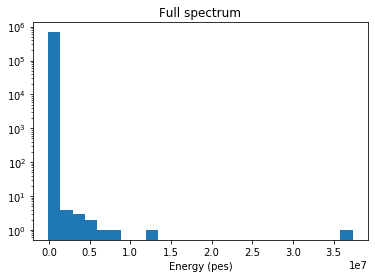

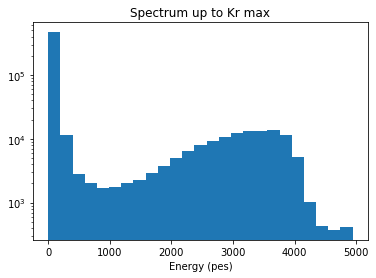

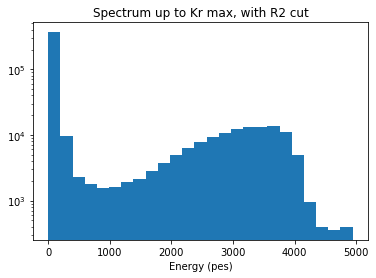

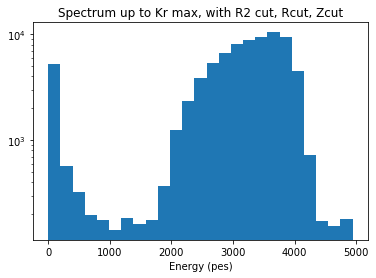

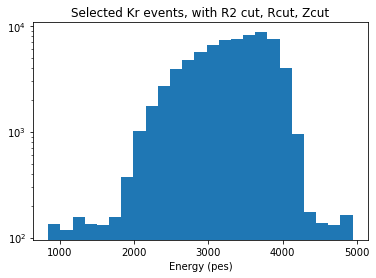

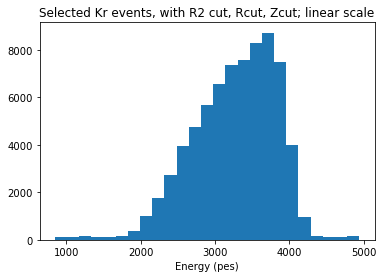

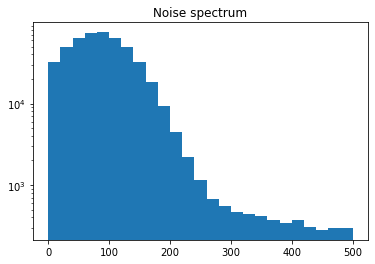

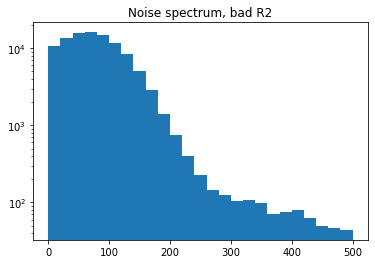

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


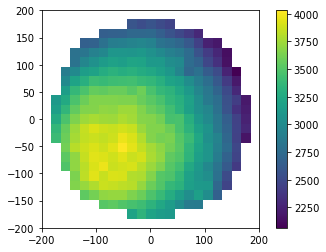

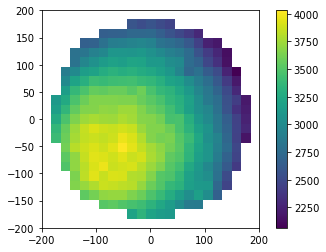

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 17.8
200000 / 582890
Est remaining = 14.0
300000 / 582890
Est remaining = 10.4
400000 / 582890
Est remaining = 6.7
500000 / 582890
Est remaining = 3.0


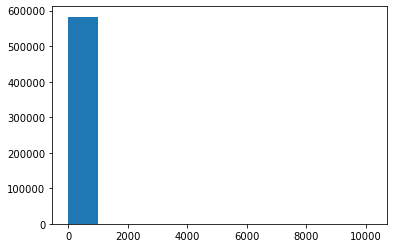

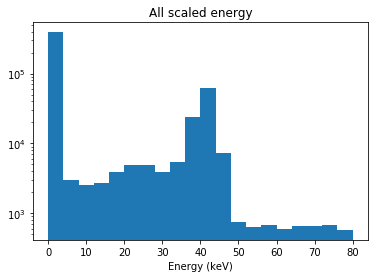

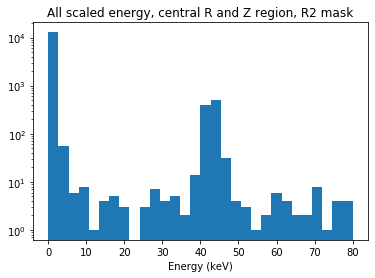

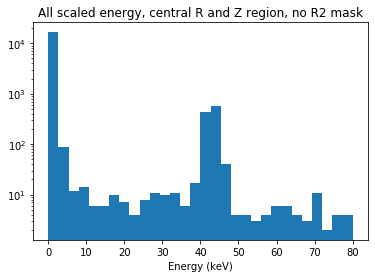

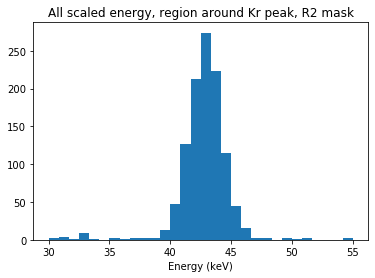

Correcting energies...
0 / 72610


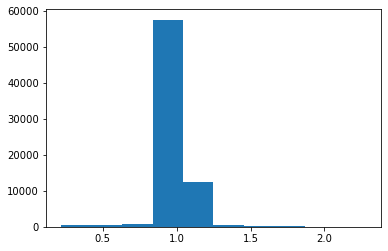

Fit a Gaussian with guess (A0, m0, s0) = (125.0, 1, 0.09093573226977235)


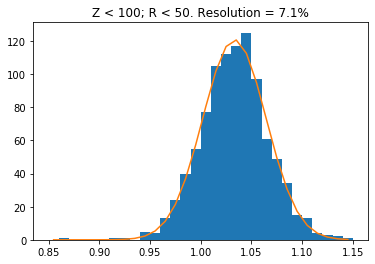

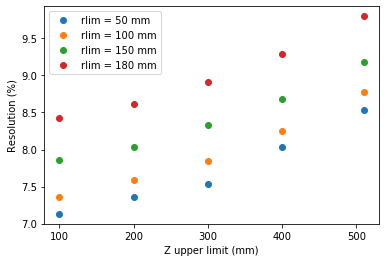

Innermost resolution =  7.13 %
Outermost resolution =  9.8 %
All resolutions: {100050: 7.130692707051996, 100100: 7.3619678940860815, 100150: 7.853097305985448, 100180: 8.42011007513894, 200050: 7.3532306343837375, 200100: 7.588765096494243, 200150: 8.038388207681008, 200180: 8.61529159870893, 300050: 7.539063271965629, 300100: 7.848347933270382, 300150: 8.328809502782113, 300180: 8.91828500830254, 400050: 8.032681407916755, 400100: 8.246557990454548, 400150: 8.680103421979155, 400180: 9.284728052597098, 510050: 8.537486789177738, 510100: 8.77315151648789, 510150: 9.179081448085398, 510180: 9.79936784224301}

================ CHECKING R2 CUT = 0.5 ================
Peak range = 896.0 , 4937.2
Selected percentage = 10.6 \%


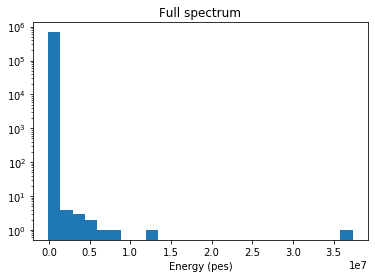

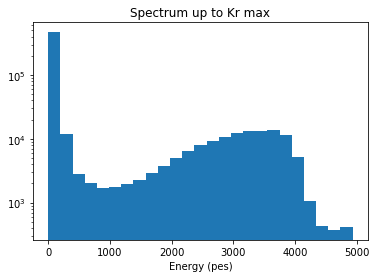

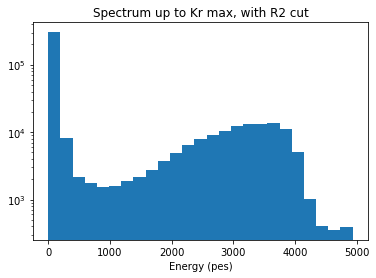

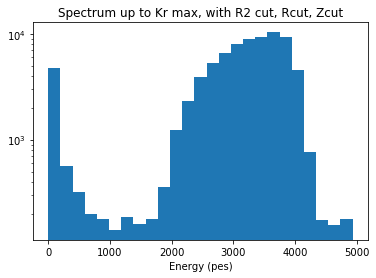

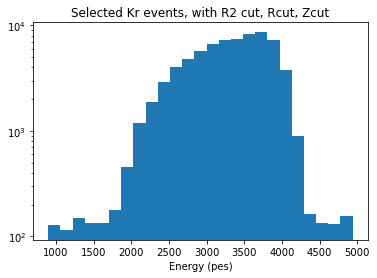

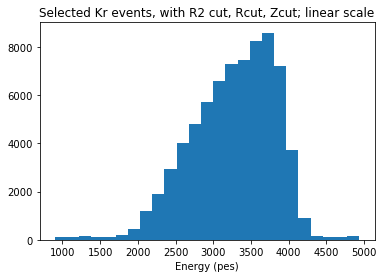

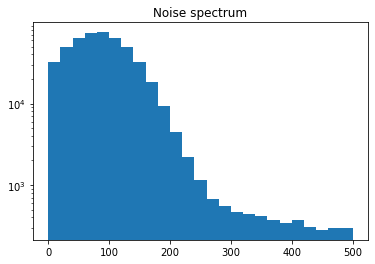

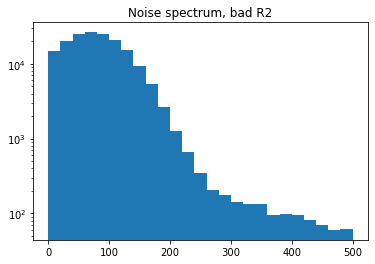

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


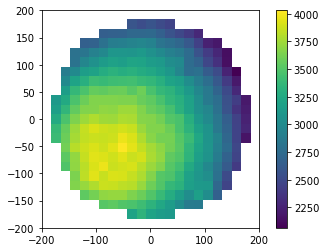

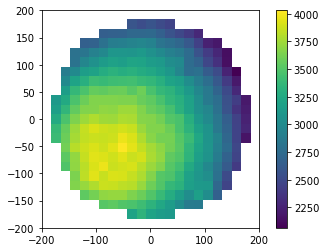

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 17.8
200000 / 582890
Est remaining = 14.5
300000 / 582890
Est remaining = 11.8
400000 / 582890
Est remaining = 7.6
500000 / 582890
Est remaining = 3.4


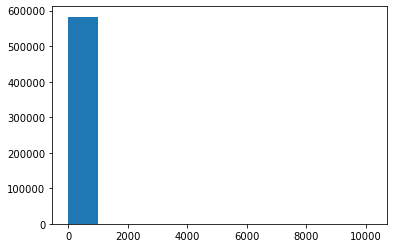

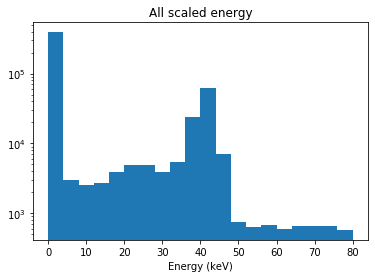

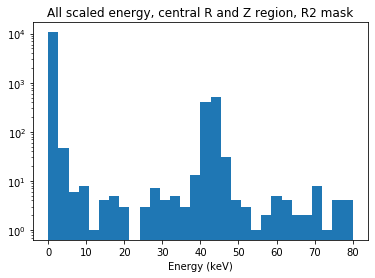

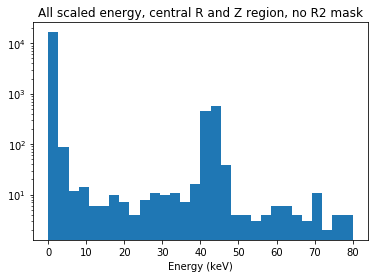

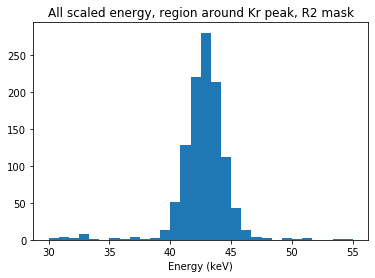

Correcting energies...
0 / 72558


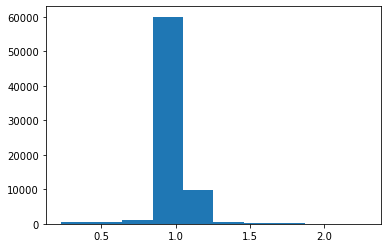

Fit a Gaussian with guess (A0, m0, s0) = (124.0, 1, 0.08741899269719146)


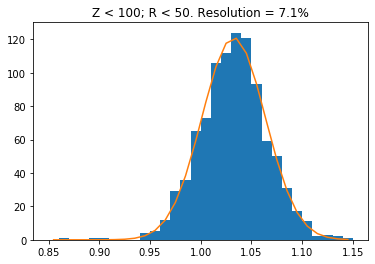

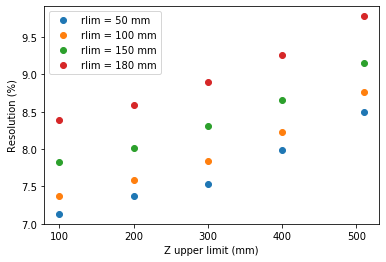

Innermost resolution =  7.13 %
Outermost resolution =  9.78 %
All resolutions: {100050: 7.131097742730168, 100100: 7.364966685838327, 100150: 7.829605155418193, 100180: 8.3939344751514, 200050: 7.3713395238057355, 200100: 7.586611629452687, 200150: 8.017265278263055, 200180: 8.59466065900622, 300050: 7.530484539427938, 300100: 7.841674686813298, 300150: 8.30799083594757, 300180: 8.898563431985886, 400050: 7.992085634997187, 400100: 8.234427945009049, 400150: 8.654504940230353, 400180: 9.261669296258127, 510050: 8.489374545957274, 510100: 8.759646131388369, 510150: 9.154961752943748, 510180: 9.777598935018133}

================ CHECKING R2 CUT = 0.6 ================
Peak range = 975.6 , 4927.8
Selected percentage = 10.6 \%


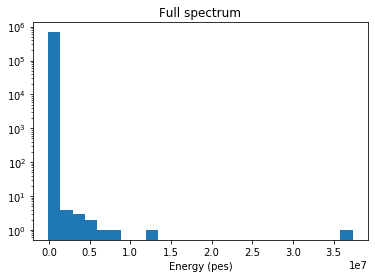

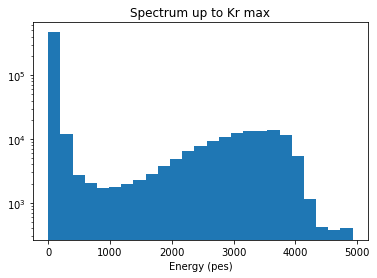

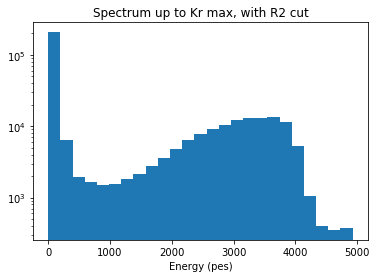

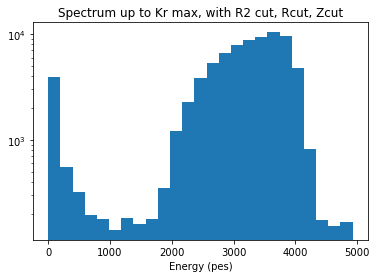

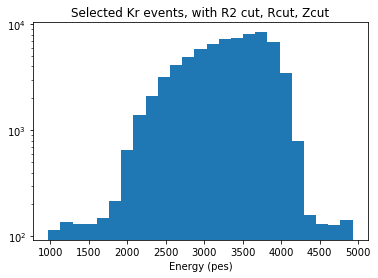

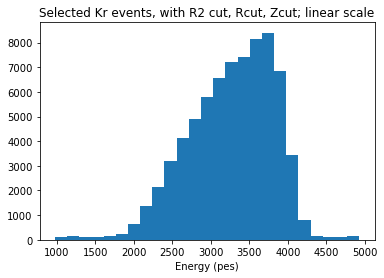

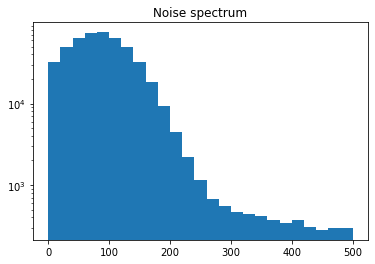

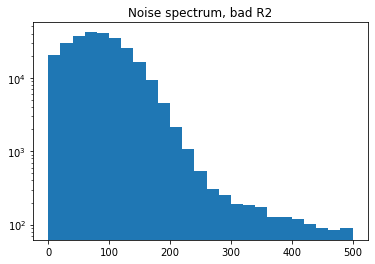

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


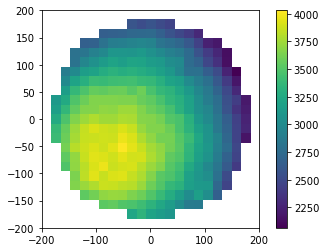

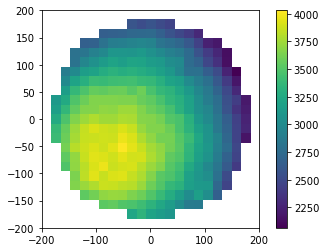

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 21.0
200000 / 582890
Est remaining = 20.2
300000 / 582890
Est remaining = 16.9
400000 / 582890
Est remaining = 10.5
500000 / 582890
Est remaining = 4.9


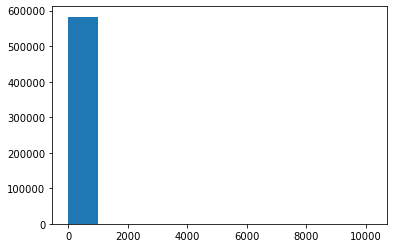

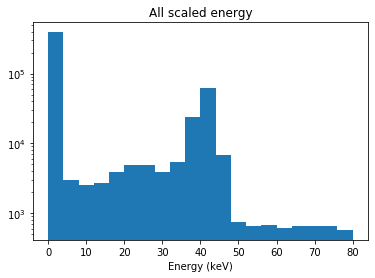

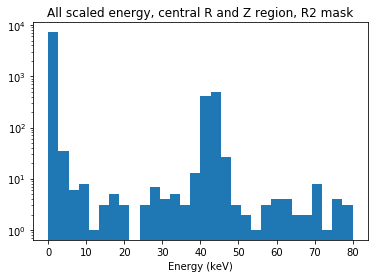

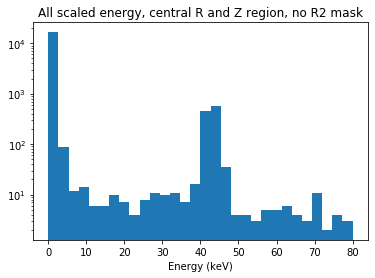

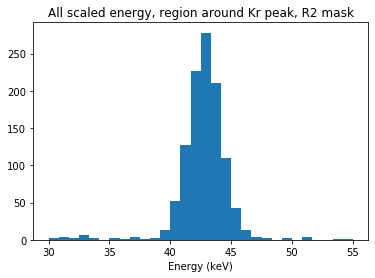

Correcting energies...
0 / 72469


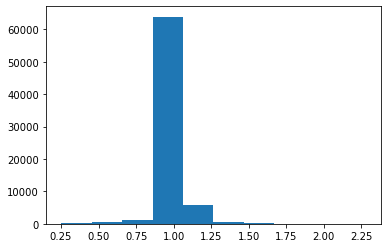

Fit a Gaussian with guess (A0, m0, s0) = (126.0, 1, 0.08399913261713005)


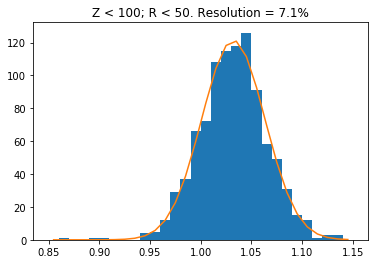

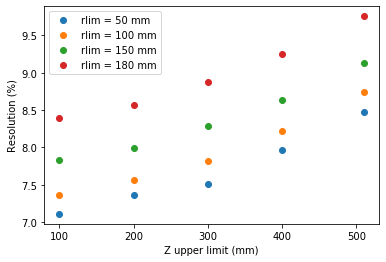

Innermost resolution =  7.11 %
Outermost resolution =  9.76 %
All resolutions: {100050: 7.110439301862623, 100100: 7.358200333105268, 100150: 7.828087894733603, 100180: 8.391503043798693, 200050: 7.3679373182999415, 200100: 7.569483443815153, 200150: 7.9935060155378475, 200180: 8.5727509154792, 300050: 7.507534466110449, 300100: 7.8236015611666625, 300150: 8.281329172437399, 300180: 8.873819033528795, 400050: 7.969862255786848, 400100: 8.219588702500777, 400150: 8.633692978206835, 400180: 9.243838068191522, 510050: 8.467875124523514, 510100: 8.745081999595365, 510150: 9.129489996565868, 510180: 9.755311547065238}

================ CHECKING R2 CUT = 0.7 ================
Peak range = 1092.5 , 4912.9
Selected percentage = 10.6 \%


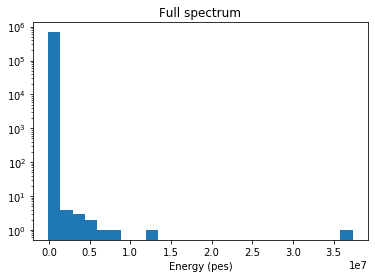

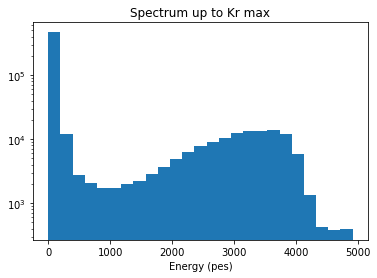

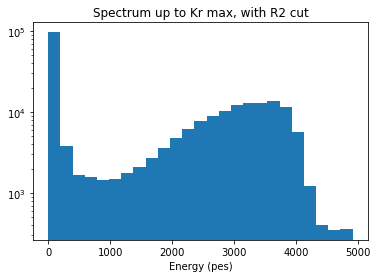

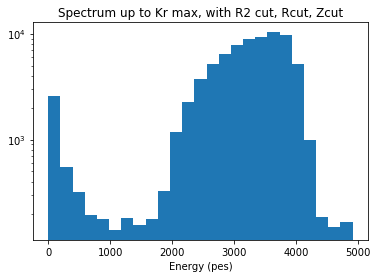

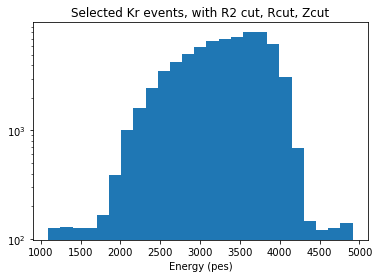

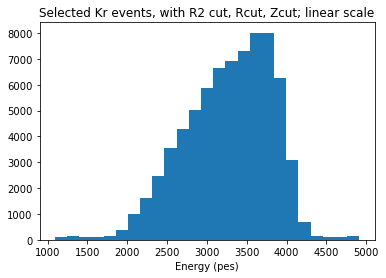

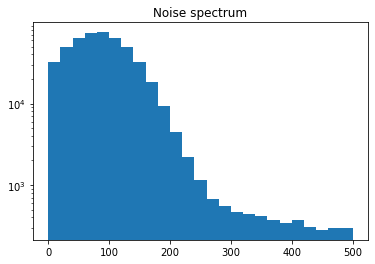

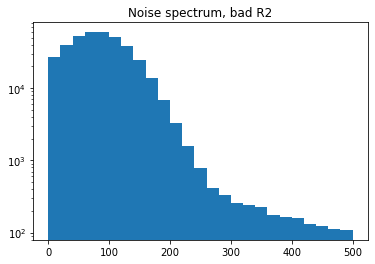

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


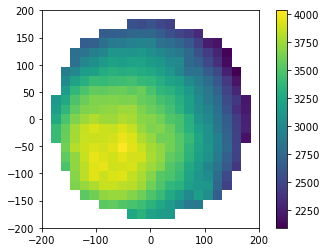

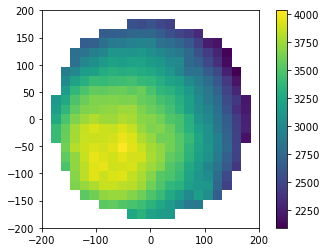

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 23.4
200000 / 582890
Est remaining = 18.6
300000 / 582890
Est remaining = 14.0
400000 / 582890
Est remaining = 9.0
500000 / 582890
Est remaining = 4.2


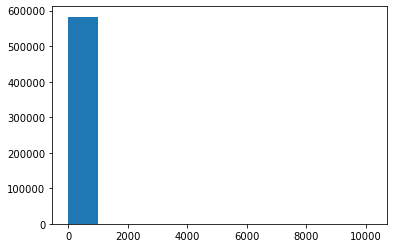

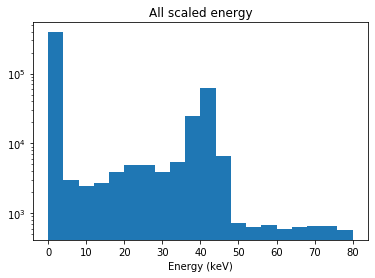

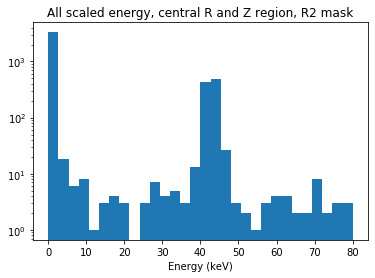

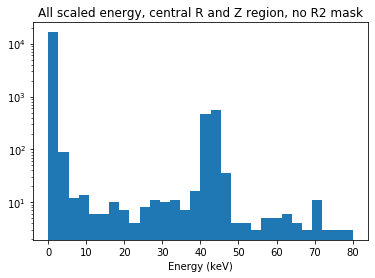

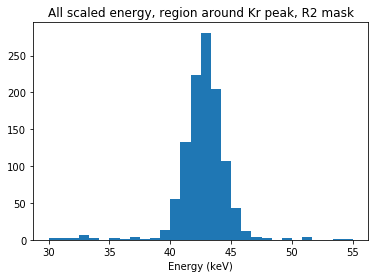

Correcting energies...
0 / 72324


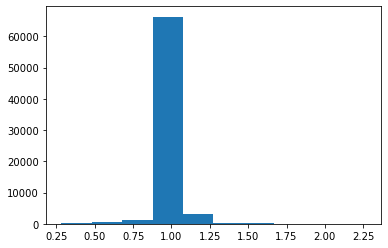

Fit a Gaussian with guess (A0, m0, s0) = (123.0, 1, 0.08053026825619046)


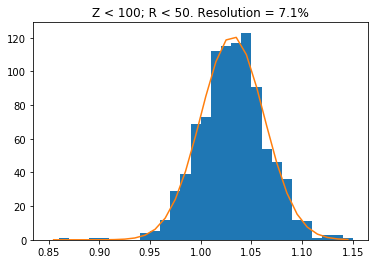

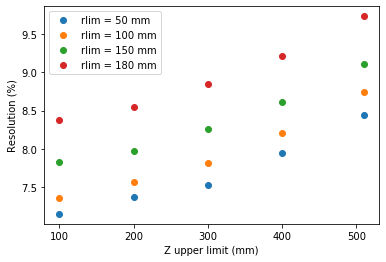

Innermost resolution =  7.15 %
Outermost resolution =  9.73 %
All resolutions: {100050: 7.148245966587718, 100100: 7.35728003944685, 100150: 7.828550760391361, 100180: 8.373905351382845, 200050: 7.371820997848089, 200100: 7.561042747881239, 200150: 7.976125464356827, 200180: 8.546717782416946, 300050: 7.532845042775484, 300100: 7.815091046407848, 300150: 8.262133601691538, 300180: 8.849040342744251, 400050: 7.948719777674702, 400100: 8.21317199379386, 400150: 8.614817046656905, 400180: 9.22021365702647, 510050: 8.439969633279231, 510100: 8.737821057045105, 510150: 9.113196388926466, 510180: 9.734527467752297}

================ CHECKING R2 CUT = 0.8 ================
Peak range = 1208.6 , 4892.9
Selected percentage = 10.5 \%


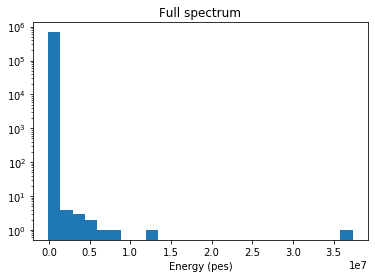

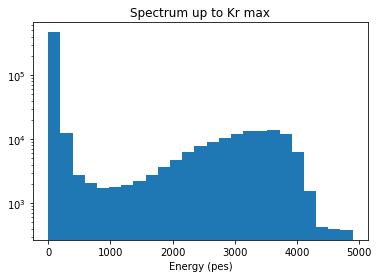

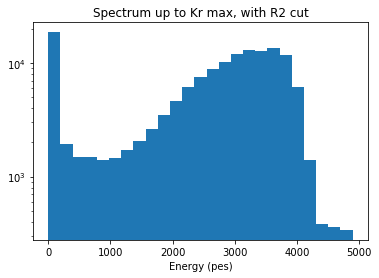

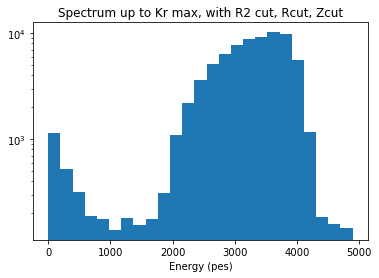

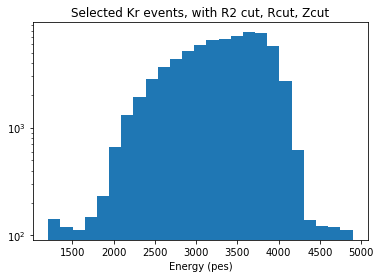

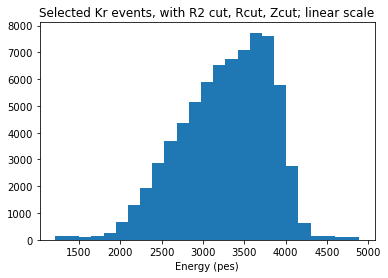

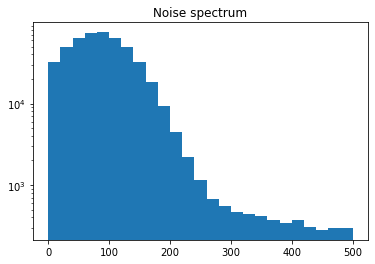

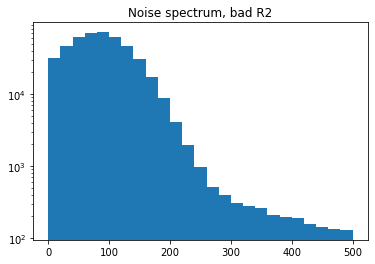

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


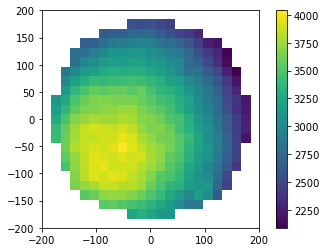

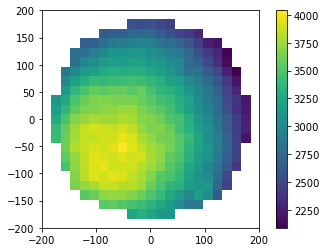

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 20.7
200000 / 582890
Est remaining = 16.3
300000 / 582890
Est remaining = 12.0
400000 / 582890
Est remaining = 7.8
500000 / 582890
Est remaining = 3.5


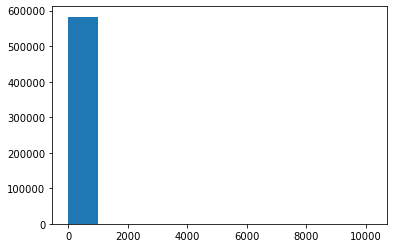

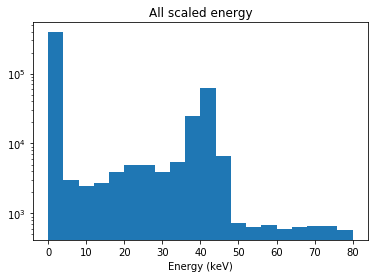

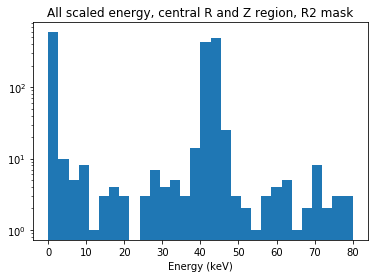

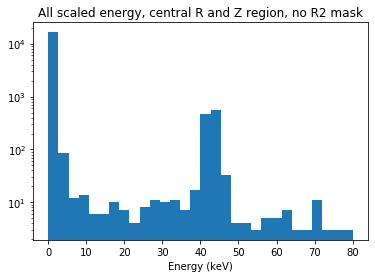

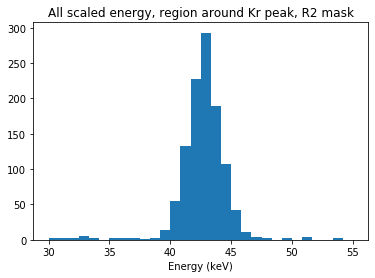

Correcting energies...
0 / 72012


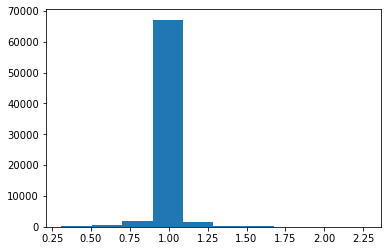

Fit a Gaussian with guess (A0, m0, s0) = (124.0, 1, 0.07752673957485416)


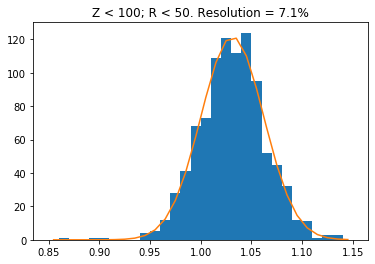

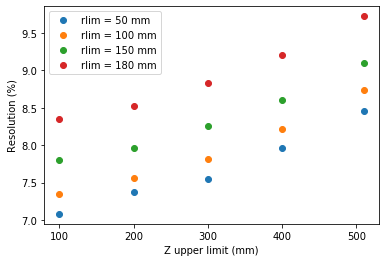

Innermost resolution =  7.08 %
Outermost resolution =  9.72 %
All resolutions: {100050: 7.080350909337273, 100100: 7.34291535897845, 100150: 7.803323137432957, 100180: 8.350355742028844, 200050: 7.3797085899712425, 200100: 7.5586562950336695, 200150: 7.960655178306065, 200180: 8.527344458186867, 300050: 7.545004683126951, 300100: 7.818287622752869, 300150: 8.253306056047577, 300180: 8.830993865612745, 400050: 7.956144595675055, 400100: 8.2098244656054, 400150: 8.607340647961479, 400180: 9.20709294975166, 510050: 8.454893585955764, 510100: 8.73528918230675, 510150: 9.101719783372529, 510180: 9.722875084379794}

================ CHECKING R2 CUT = 0.9 ================
Peak range = 1259.5 , 4881.2
Selected percentage = 10.5 \%


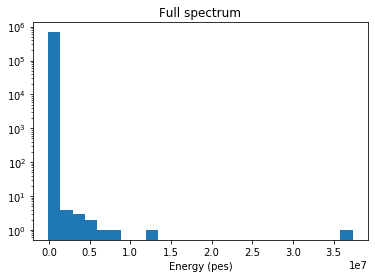

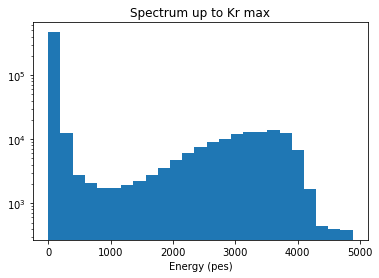

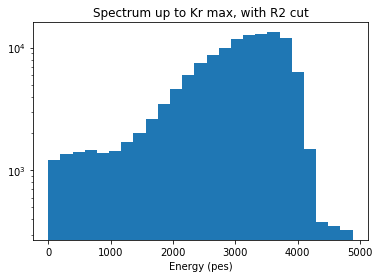

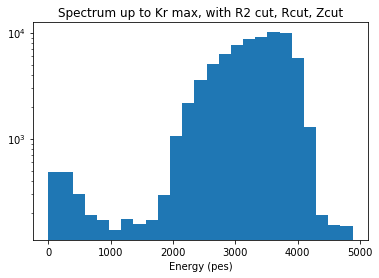

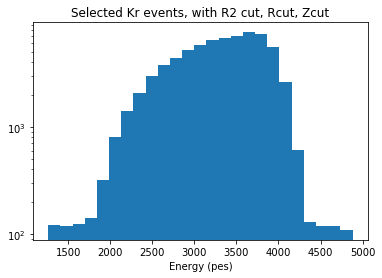

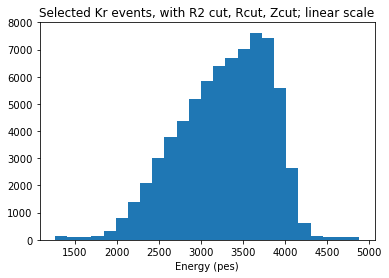

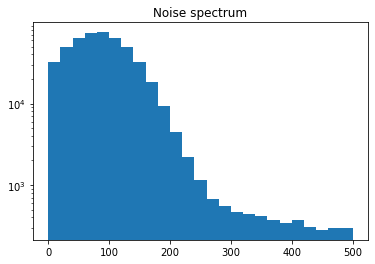

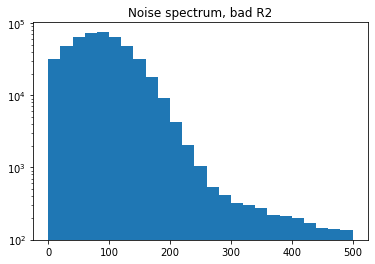

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


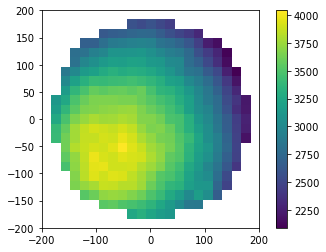

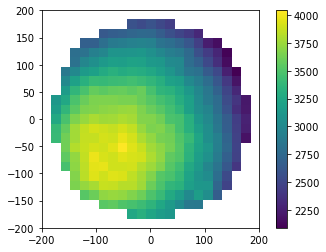

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 19.2
200000 / 582890
Est remaining = 14.5
300000 / 582890
Est remaining = 11.5
400000 / 582890
Est remaining = 7.4
500000 / 582890
Est remaining = 3.4


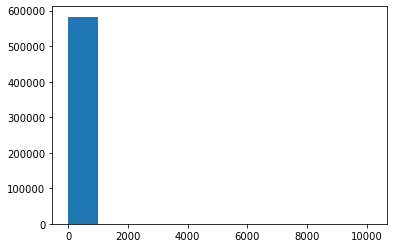

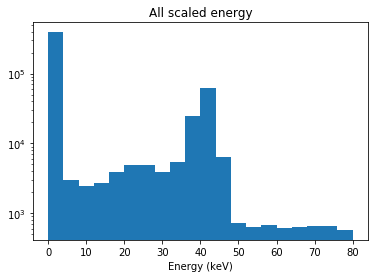

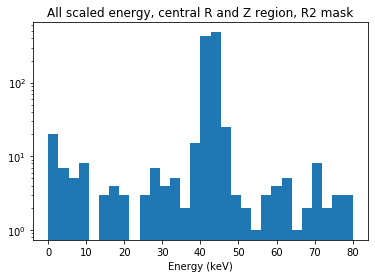

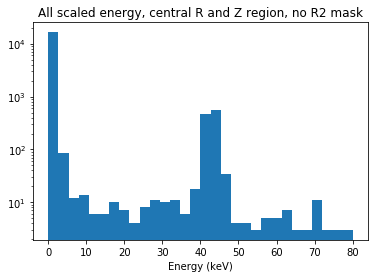

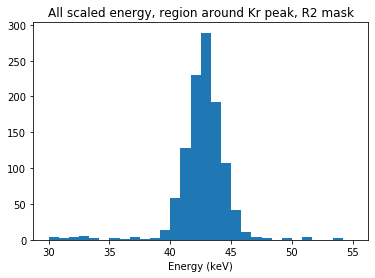

Correcting energies...
0 / 71719


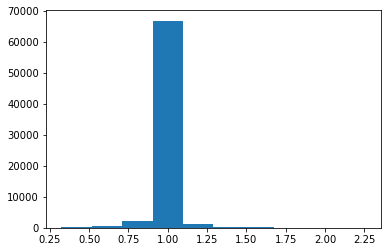

Fit a Gaussian with guess (A0, m0, s0) = (126.0, 1, 0.07763137253848336)


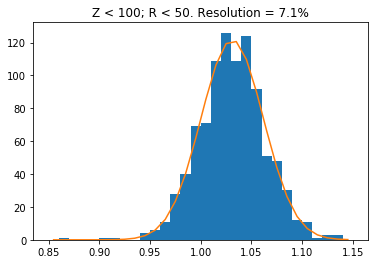

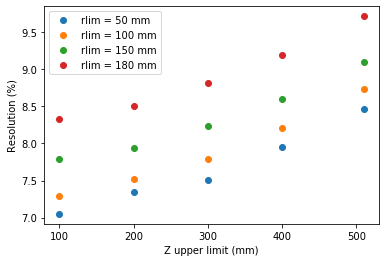

Innermost resolution =  7.05 %
Outermost resolution =  9.71 %
All resolutions: {100050: 7.050307828719949, 100100: 7.287934441866619, 100150: 7.782957104592757, 100180: 8.33117225928825, 200050: 7.345141967974677, 200100: 7.520817483825194, 200150: 7.937049326465366, 200180: 8.507043333892572, 300050: 7.508753848325098, 300100: 7.793408934352116, 300150: 8.237972285939595, 300180: 8.817073282397205, 400050: 7.9449134636249275, 400100: 8.2010989112372, 400150: 8.597307688779898, 400180: 9.195465226275035, 510050: 8.457317618372066, 510100: 8.731679278689814, 510150: 9.094446521204775, 510180: 9.710628369444054}

================ CHECKING R2 CUT = 0.92 ================
Peak range = 1267.4 , 4879.0
Selected percentage = 10.5 \%


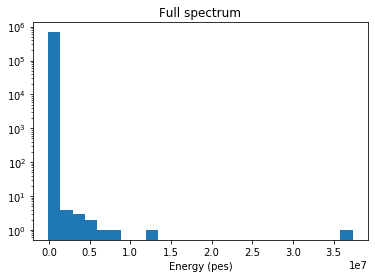

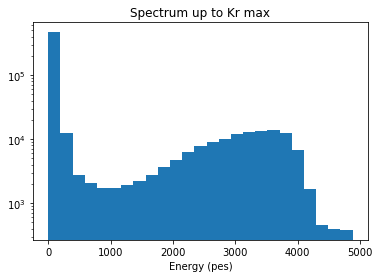

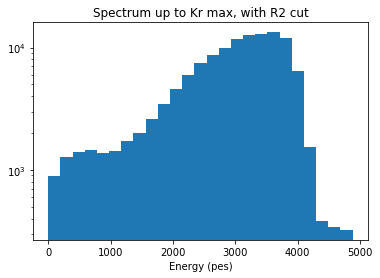

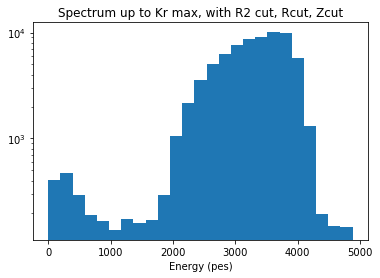

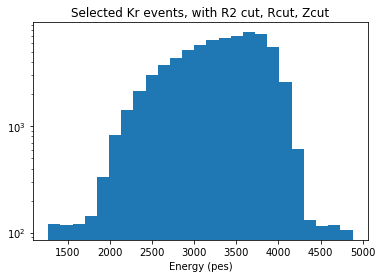

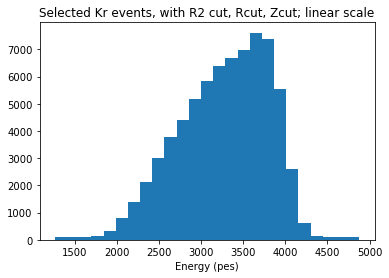

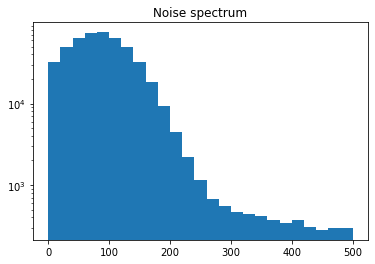

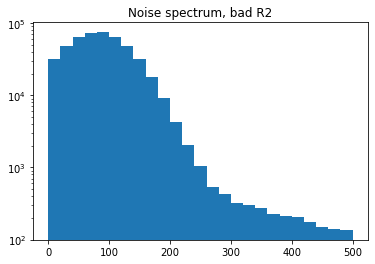

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


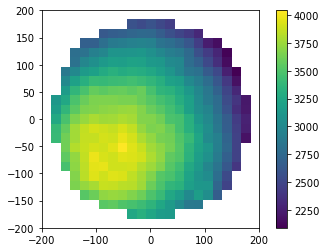

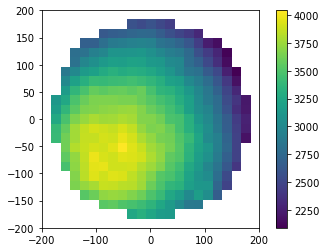

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 19.5
200000 / 582890
Est remaining = 15.3
300000 / 582890
Est remaining = 12.5
400000 / 582890
Est remaining = 8.0
500000 / 582890
Est remaining = 3.6


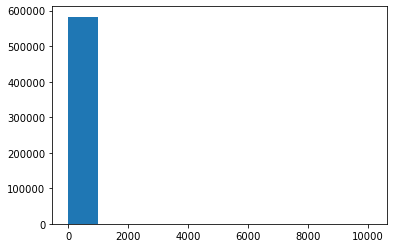

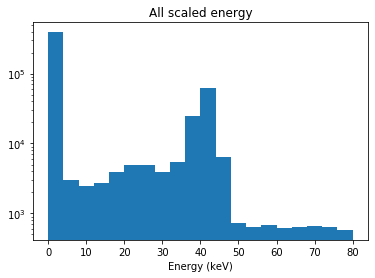

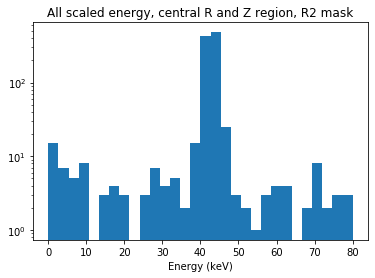

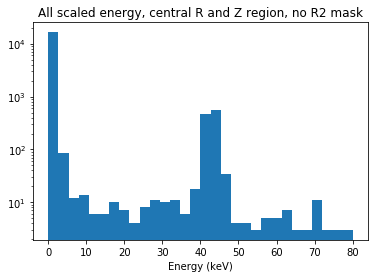

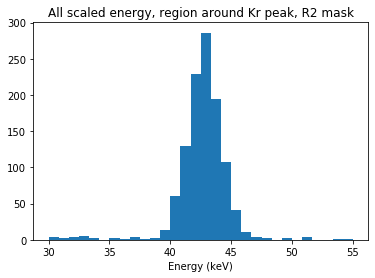

Correcting energies...
0 / 71651


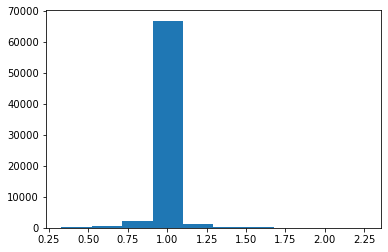

Fit a Gaussian with guess (A0, m0, s0) = (122.0, 1, 0.0772384779643261)


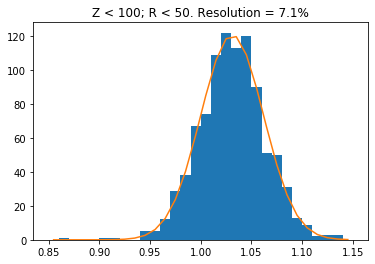

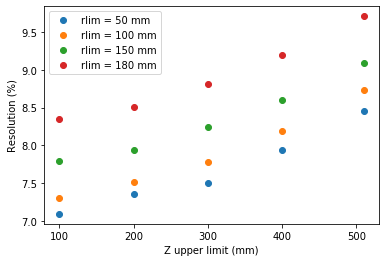

Innermost resolution =  7.09 %
Outermost resolution =  9.71 %
All resolutions: {100050: 7.089906820338944, 100100: 7.305485388280932, 100150: 7.796743192637662, 100180: 8.341723460308627, 200050: 7.347734149103606, 200100: 7.519366867911372, 200150: 7.940463856393953, 200180: 8.509288065453703, 300050: 7.503486568991868, 300100: 7.783213558185793, 300150: 8.23594804680046, 300180: 8.815152767486556, 400050: 7.934841420040521, 400100: 8.190959042695782, 400150: 8.597006280746092, 400180: 9.194697010897544, 510050: 8.455469965144536, 510100: 8.726865251215933, 510150: 9.095820570529684, 510180: 9.710315360650984}

================ CHECKING R2 CUT = 0.94 ================
Peak range = 1281.3 , 4875.6
Selected percentage = 10.5 \%


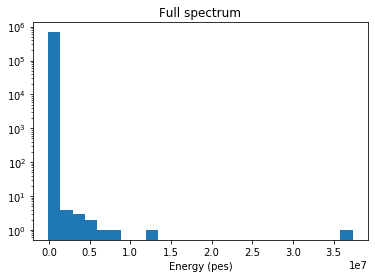

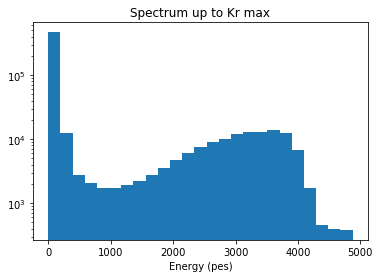

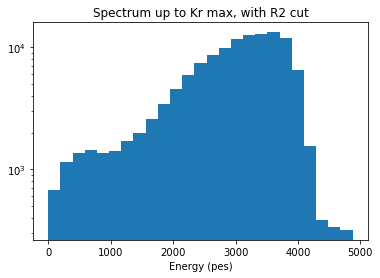

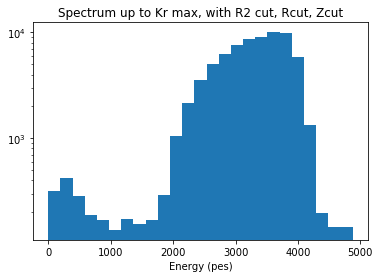

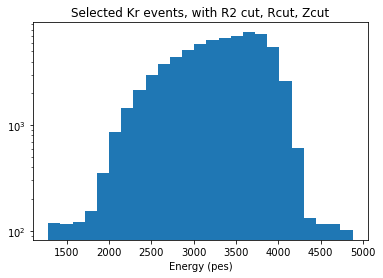

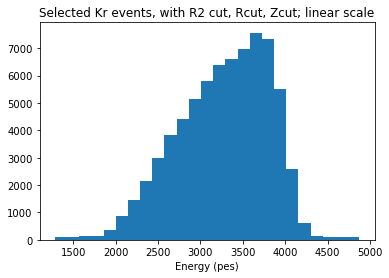

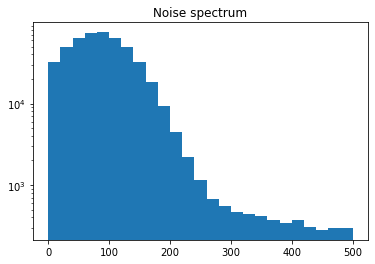

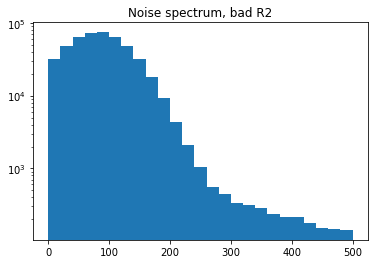

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


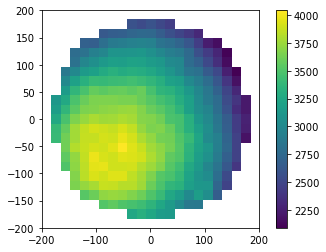

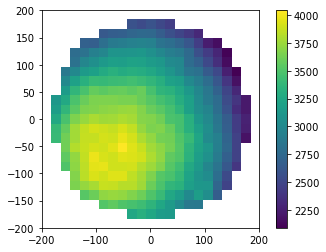

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 14.7
200000 / 582890
Est remaining = 11.5
300000 / 582890
Est remaining = 8.3
400000 / 582890
Est remaining = 5.2
500000 / 582890
Est remaining = 2.3


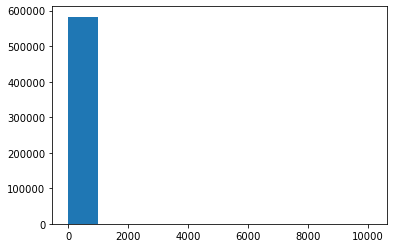

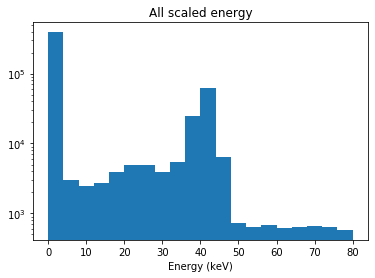

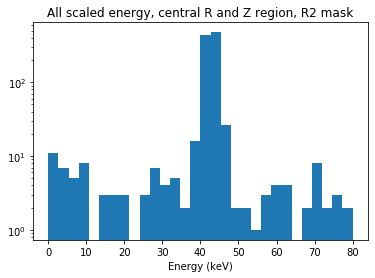

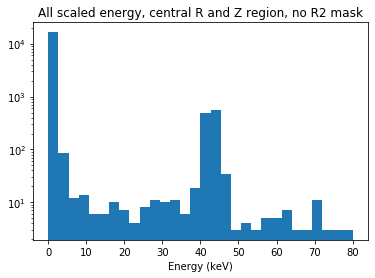

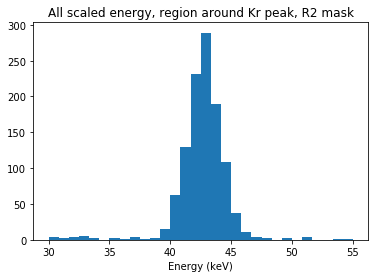

Correcting energies...
0 / 71560


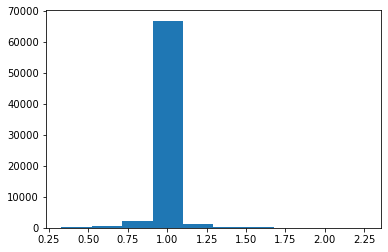

Fit a Gaussian with guess (A0, m0, s0) = (124.0, 1, 0.07184755701266309)


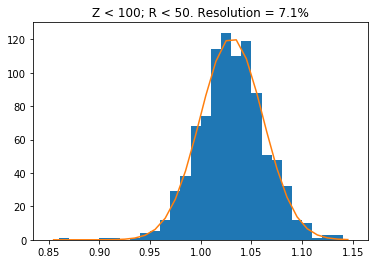

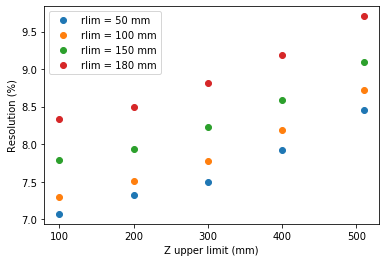

Innermost resolution =  7.07 %
Outermost resolution =  9.7 %
All resolutions: {100050: 7.071110267346105, 100100: 7.294778101180927, 100150: 7.787817346086695, 100180: 8.336226913164047, 200050: 7.326166500758117, 200100: 7.509280424607052, 200150: 7.931316983874122, 200180: 8.498704716809323, 300050: 7.491712599755239, 300100: 7.778440190560141, 300150: 8.230721441925922, 300180: 8.808694935616831, 400050: 7.926707516120719, 400100: 8.188721787745257, 400150: 8.59393850292199, 400180: 9.189060482575238, 510050: 8.456866571750368, 510100: 8.724177852835261, 510150: 9.091644752530081, 510180: 9.704231057378522}

================ CHECKING R2 CUT = 0.96 ================
Peak range = 1295.1 , 4871.7
Selected percentage = 10.5 \%


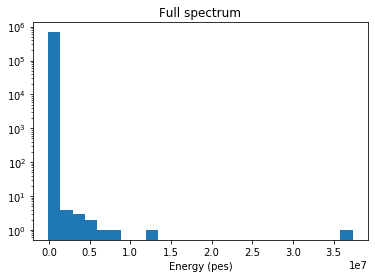

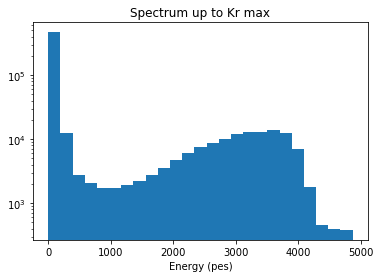

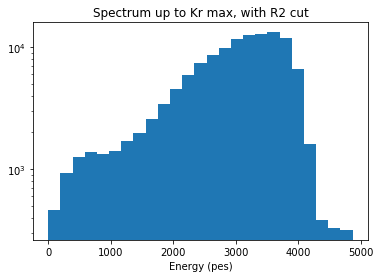

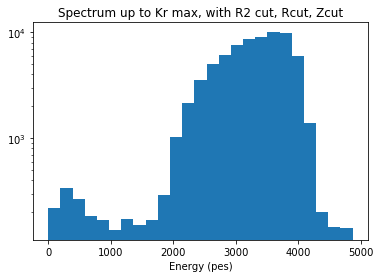

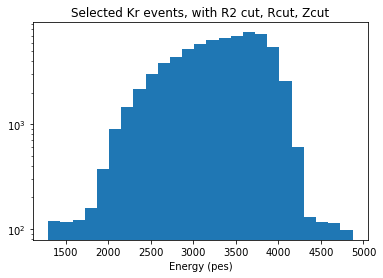

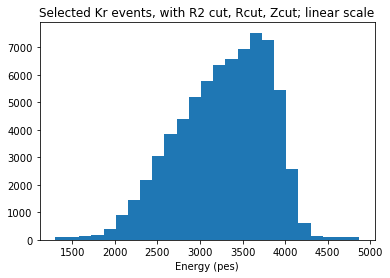

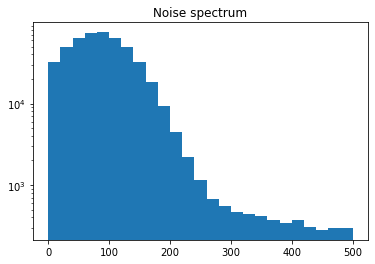

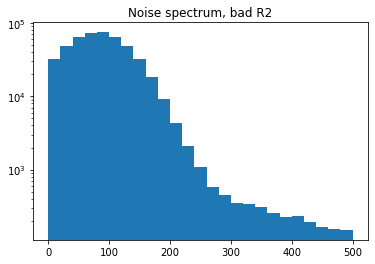

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


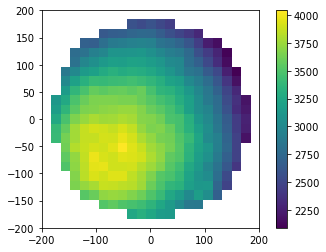

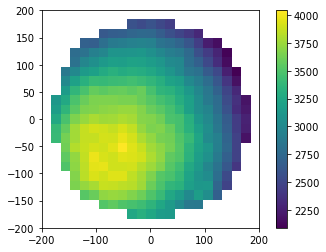

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 14.9
200000 / 582890
Est remaining = 11.7
300000 / 582890
Est remaining = 8.1
400000 / 582890
Est remaining = 5.0
500000 / 582890
Est remaining = 2.3


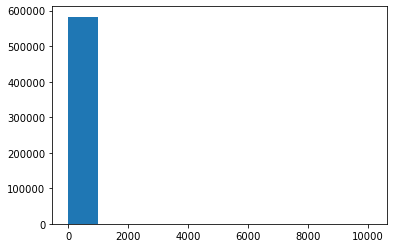

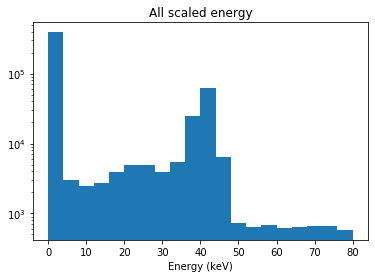

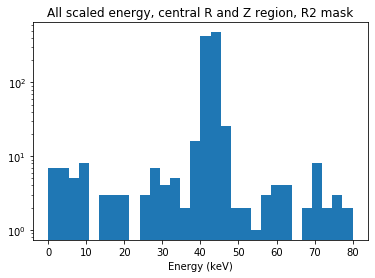

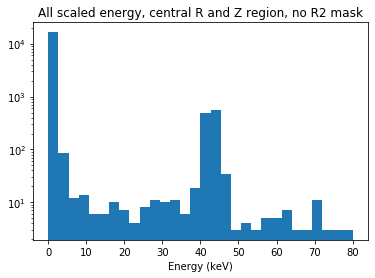

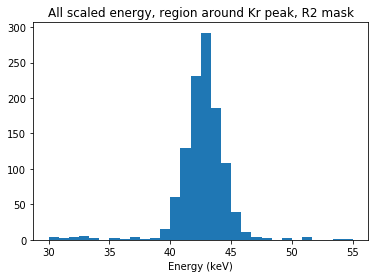

Correcting energies...
0 / 71452


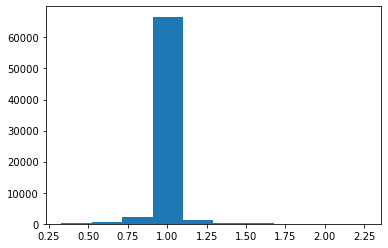

Fit a Gaussian with guess (A0, m0, s0) = (122.0, 1, 0.07185227412316034)


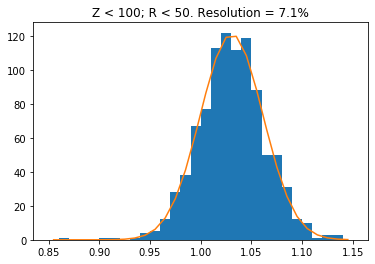

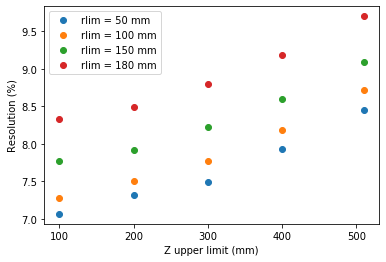

Innermost resolution =  7.07 %
Outermost resolution =  9.7 %
All resolutions: {100050: 7.065974832817408, 100100: 7.273170487415753, 100150: 7.77634352919124, 100180: 8.32753702732942, 200050: 7.315250395318786, 200100: 7.498249280720626, 200150: 7.922166369623557, 200180: 8.490423987316488, 300050: 7.485305874683568, 300100: 7.769117411302976, 300150: 8.222263260228859, 300180: 8.79951814994314, 400050: 7.923727922528026, 400100: 8.18406191439292, 400150: 8.59088982664767, 400180: 9.181698742553818, 510050: 8.45461171685642, 510100: 8.720853124872187, 510150: 9.08988611853703, 510180: 9.697976721217712}

================ CHECKING R2 CUT = 0.98 ================
Peak range = 1320.7 , 4864.7
Selected percentage = 10.4 \%


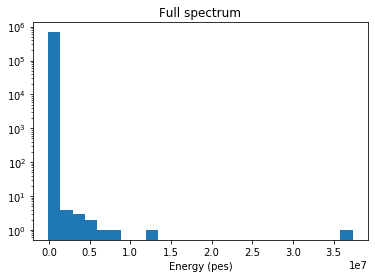

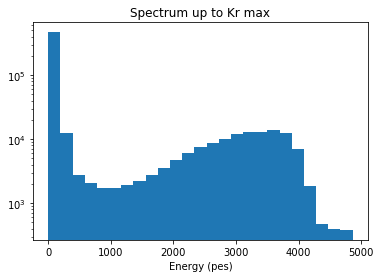

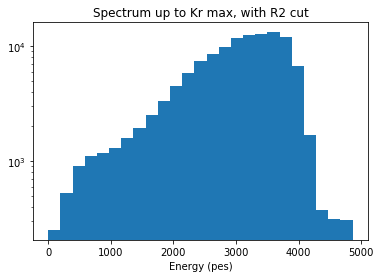

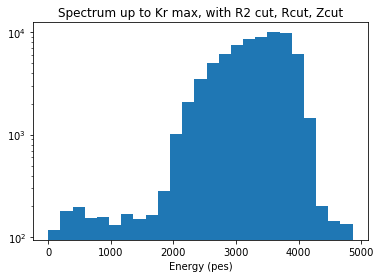

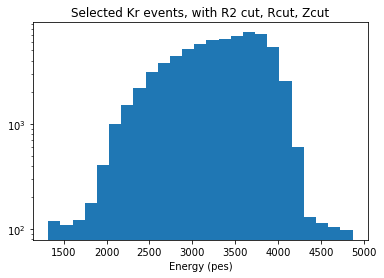

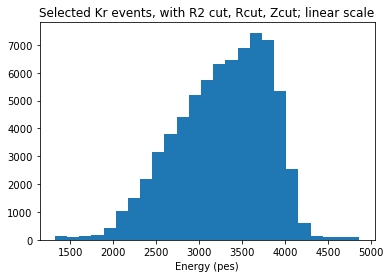

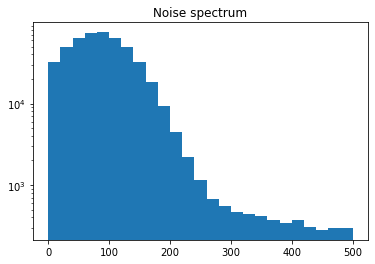

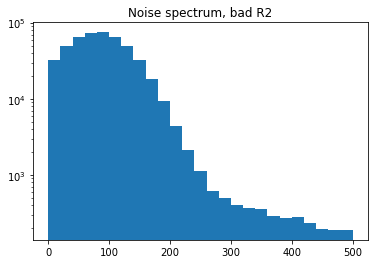

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


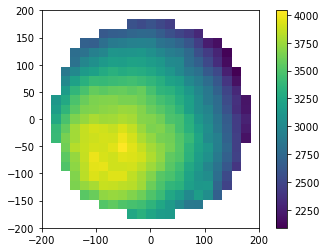

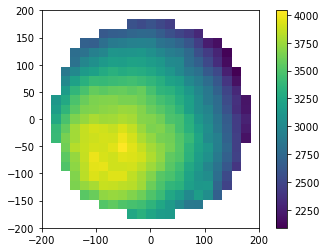

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 11.4
200000 / 582890
Est remaining = 10.9
300000 / 582890
Est remaining = 9.0
400000 / 582890
Est remaining = 5.8
500000 / 582890
Est remaining = 2.6


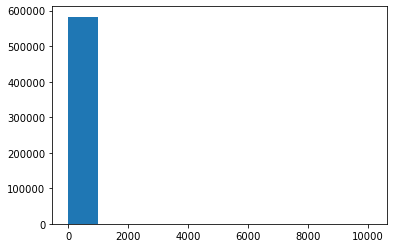

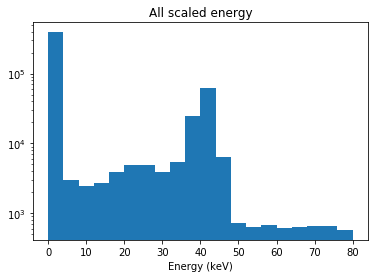

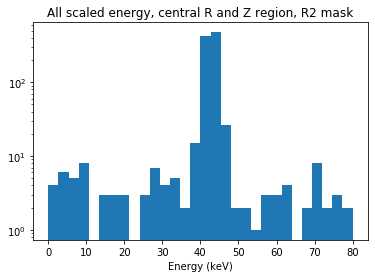

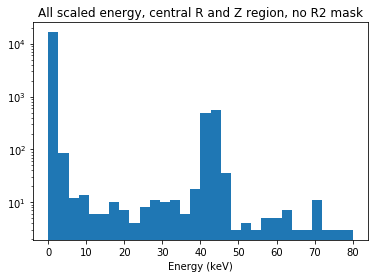

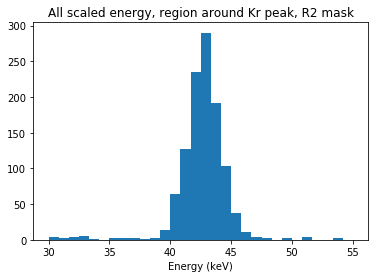

Correcting energies...
0 / 71157


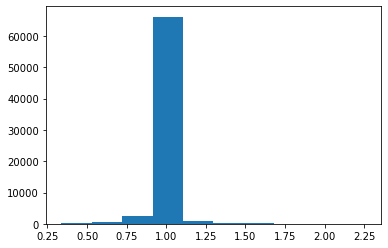

Fit a Gaussian with guess (A0, m0, s0) = (123.0, 1, 0.07189966697514537)


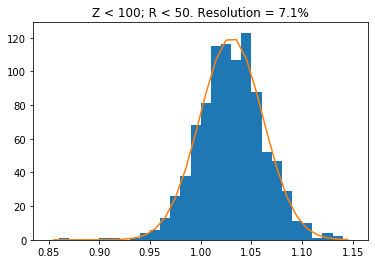

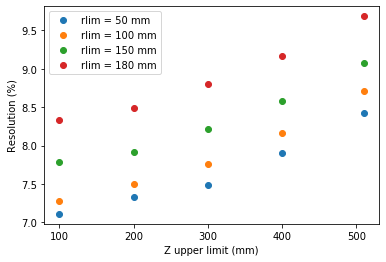

Innermost resolution =  7.11 %
Outermost resolution =  9.69 %
All resolutions: {100050: 7.107894719470274, 100100: 7.269967570114718, 100150: 7.781754073771713, 100180: 8.337826778814277, 200050: 7.333952181759258, 200100: 7.494881246651255, 200150: 7.920365695041024, 200180: 8.493222603644751, 300050: 7.482232447989176, 300100: 7.762074719927265, 300150: 8.217410042494281, 300180: 8.797287325542799, 400050: 7.898447512628169, 400100: 8.169417031671044, 400150: 8.582216603895347, 400180: 9.172970095271147, 510050: 8.41881978469648, 510100: 8.706212094891132, 510150: 9.07681469462017, 510180: 9.685525638510432}

================ CHECKING R2 CUT = 0.99 ================
Peak range = 1357.1 , 4856.6
Selected percentage = 10.2 \%


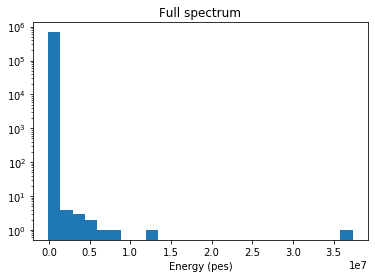

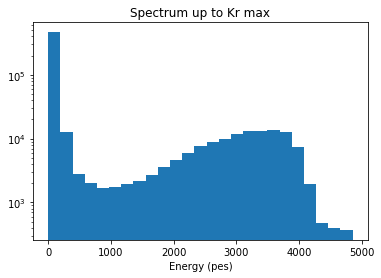

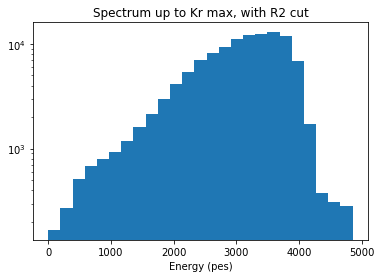

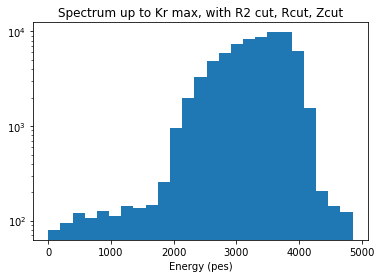

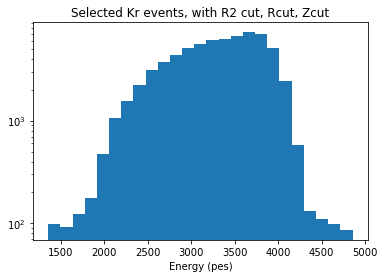

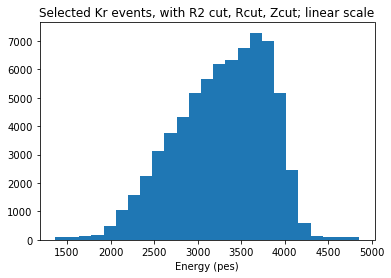

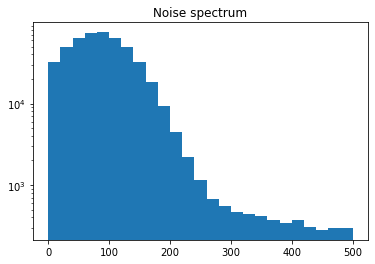

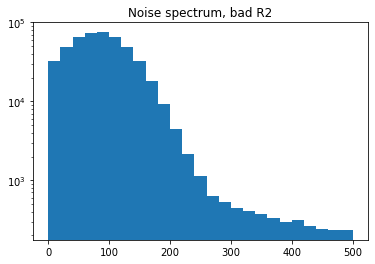

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


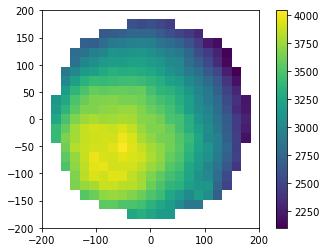

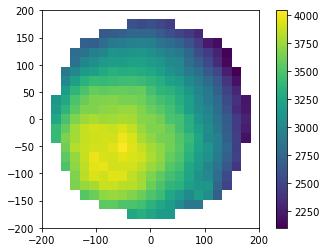

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 11.8
200000 / 582890
Est remaining = 9.2
300000 / 582890
Est remaining = 6.9
400000 / 582890
Est remaining = 4.5
500000 / 582890
Est remaining = 2.0


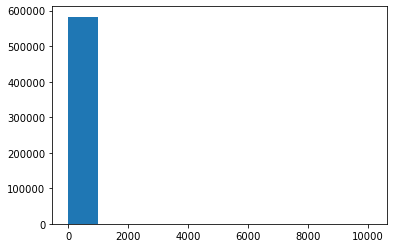

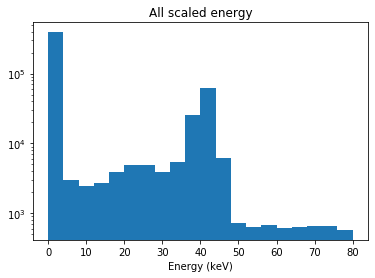

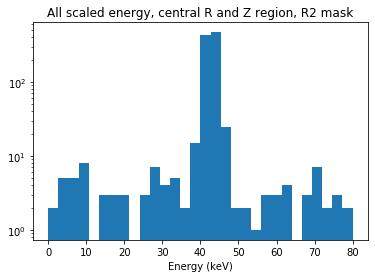

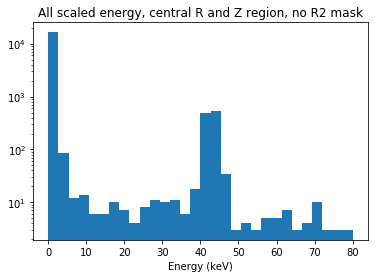

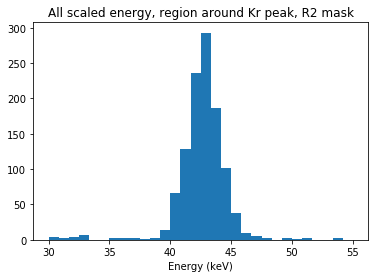

Correcting energies...
0 / 70007


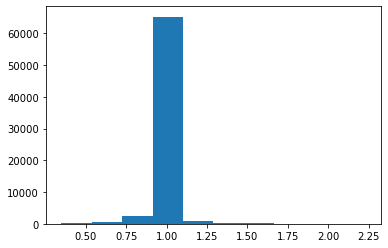

Fit a Gaussian with guess (A0, m0, s0) = (119.0, 1, 0.072073686552504)


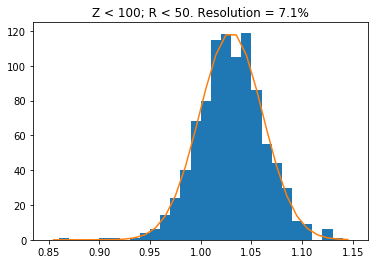

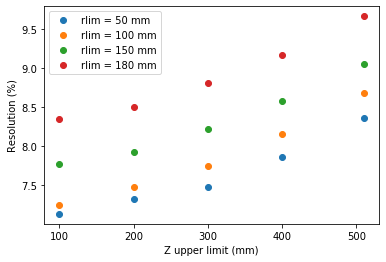

Innermost resolution =  7.13 %
Outermost resolution =  9.67 %
All resolutions: {100050: 7.128159676645252, 100100: 7.241960748709462, 100150: 7.7705974711404, 100180: 8.347093450679086, 200050: 7.324764727985954, 200100: 7.4728314516186245, 200150: 7.918769683696202, 200180: 8.500160703801175, 300050: 7.46767005162069, 300100: 7.7454757549994095, 300150: 8.2183950255817, 300180: 8.803017242057154, 400050: 7.859038161265858, 400100: 8.157855153212347, 400150: 8.571160412004726, 400180: 9.16472090305736, 510050: 8.356038532927718, 510100: 8.676955175259872, 510150: 9.056727343221992, 510180: 9.665229327729092}

================ CHECKING R2 CUT = 0.995 ================
Peak range = 1412.3 , 4855.8
Selected percentage = 9.0 \%


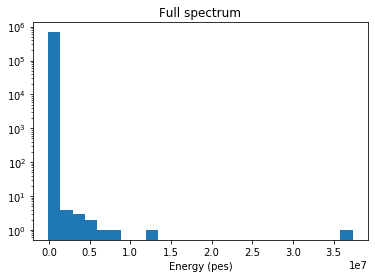

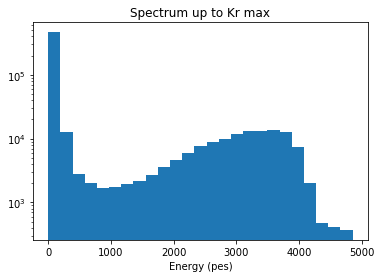

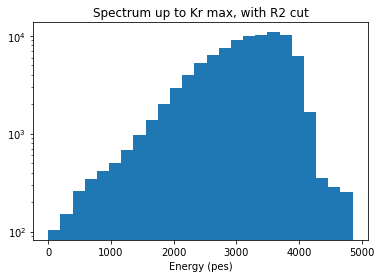

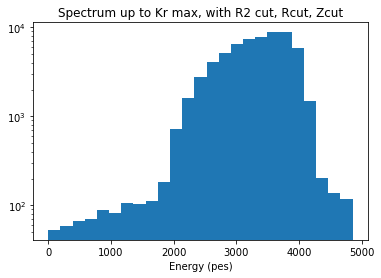

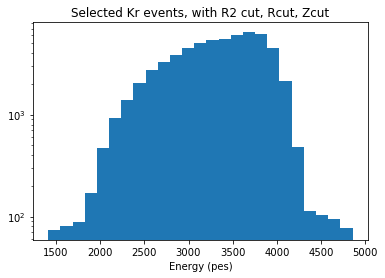

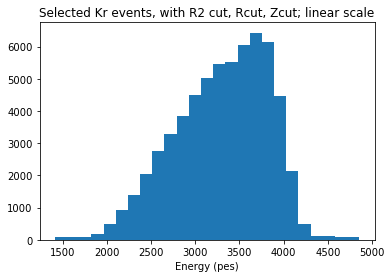

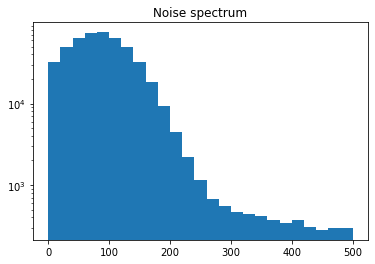

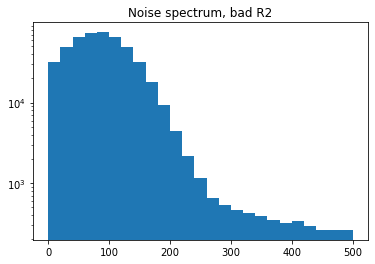

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


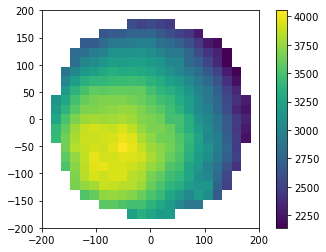

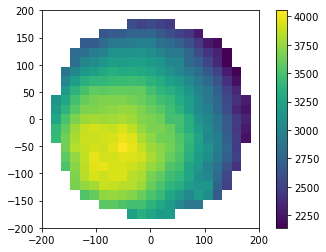

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 10.9
200000 / 582890
Est remaining = 8.4
300000 / 582890
Est remaining = 6.4
400000 / 582890
Est remaining = 4.3
500000 / 582890
Est remaining = 1.9


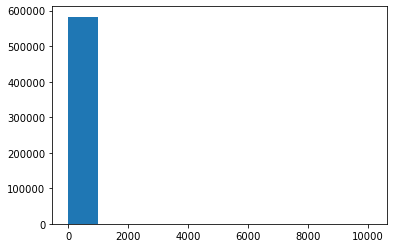

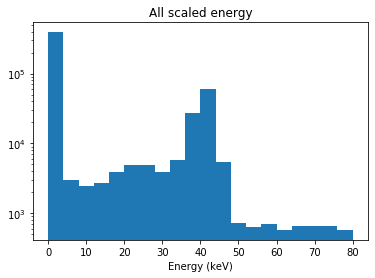

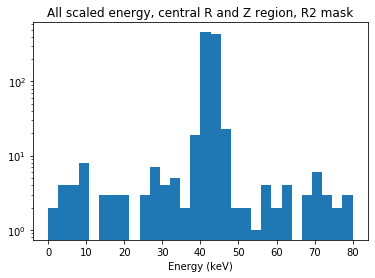

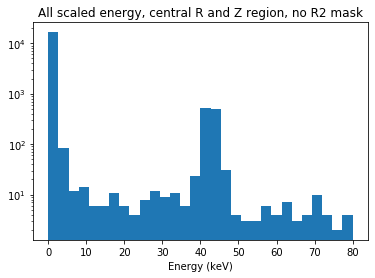

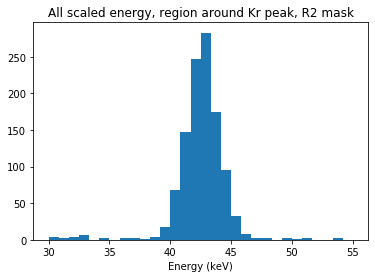

Correcting energies...
0 / 61684


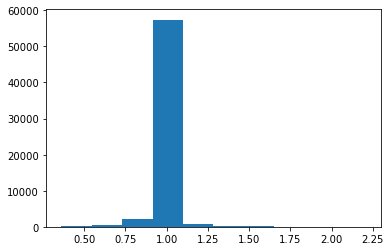

Fit a Gaussian with guess (A0, m0, s0) = (133.0, 1, 0.0687771438963943)


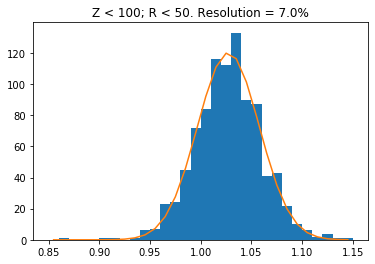

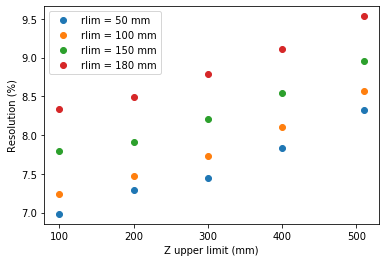

Innermost resolution =  6.98 %
Outermost resolution =  9.53 %
All resolutions: {100050: 6.983229638410047, 100100: 7.237407516680717, 100150: 7.795855425477221, 100180: 8.339489146617632, 200050: 7.293481458594332, 200100: 7.470759688039343, 200150: 7.910152437526229, 200180: 8.491680102084253, 300050: 7.445461105968019, 300100: 7.725837232932284, 300150: 8.2093992219868, 300180: 8.78254160413303, 400050: 7.833158231355732, 400100: 8.104503901445327, 400150: 8.537987077670453, 400180: 9.110673993663953, 510050: 8.321419019321471, 510100: 8.567339756813949, 510150: 8.958211966290186, 510180: 9.533499773247737}


In [19]:
# r2 scan
r2s = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.995])
res_vs_zr_vs_r2 = []
goodfit = []
for r2 in r2s:
    print('\n================ CHECKING R2 CUT =', r2, '================')
    try:
        self_res_vs_zr = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, r2)
        res_vs_zr_vs_r2.append(self_res_vs_zr)
        goodfit.append(True)
    except:
        goodfit.append(False)
goodfit = np.array(goodfit)

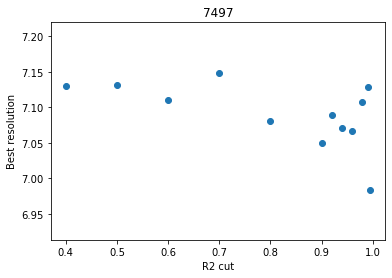

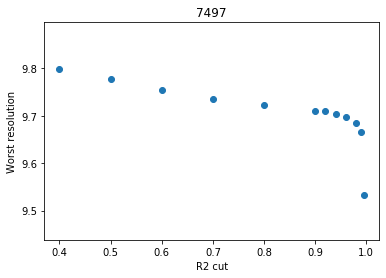

In [20]:
r2inner = [ list(x.values())[0] for x in res_vs_zr_vs_r2 ]
r2outer = [ list(x.values())[-1] for x in res_vs_zr_vs_r2 ]

plt.plot(r2s[goodfit], r2inner, 'o')
plt.ylim(min(r2inner)*0.99, max(r2inner)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Best resolution')
plt.show()

plt.plot(r2s[goodfit], r2outer, 'o')
plt.ylim(min(r2outer)*0.99, max(r2outer)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Worst resolution')
plt.show()

Peak range = 1259.5 , 4881.2
Selected percentage = 10.5 \%


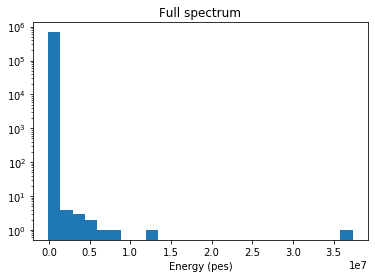

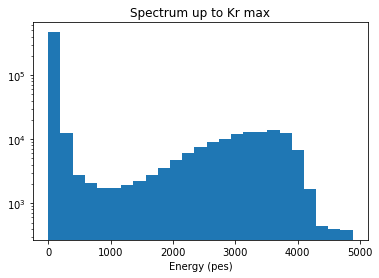

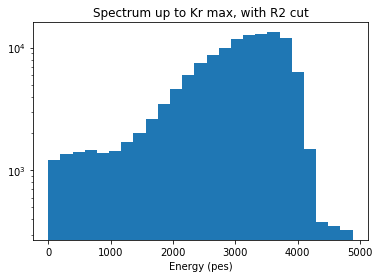

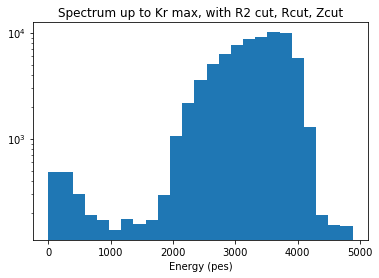

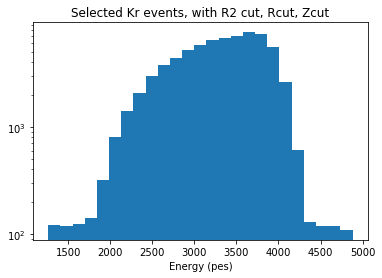

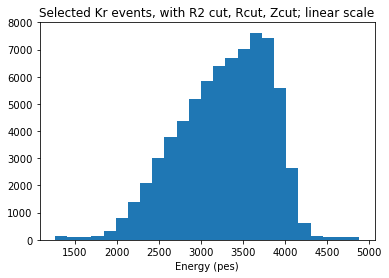

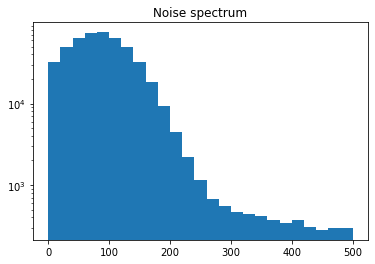

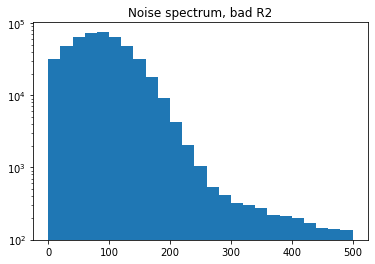

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


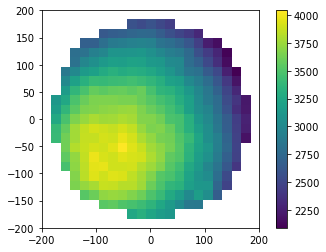

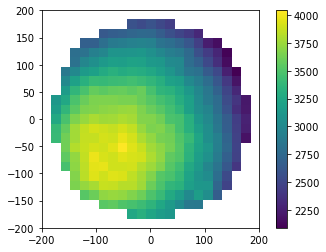

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 9.3
200000 / 582890
Est remaining = 7.3
300000 / 582890
Est remaining = 5.5
400000 / 582890
Est remaining = 3.5
500000 / 582890
Est remaining = 1.6


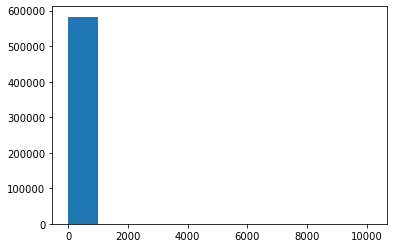

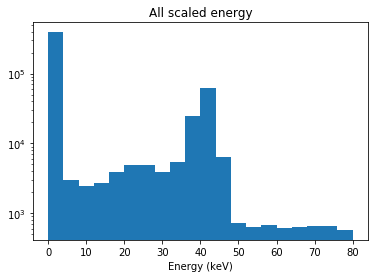

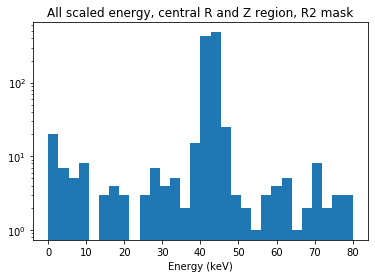

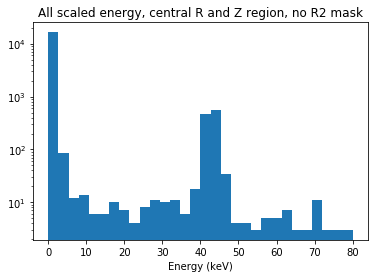

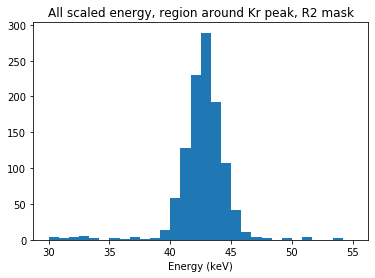

Correcting energies...
0 / 71719


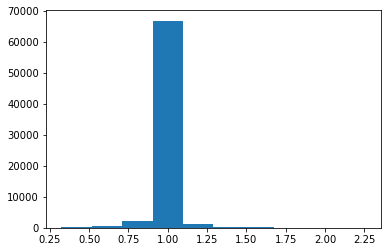

Fit a Gaussian with guess (A0, m0, s0) = (126.0, 1, 0.07763137253848336)


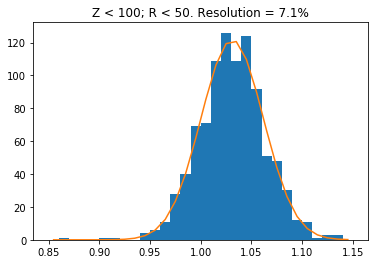

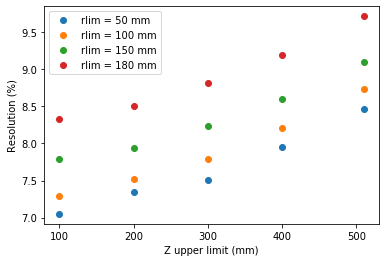

Innermost resolution =  7.05 %
Outermost resolution =  9.71 %
All resolutions: {100050: 7.050307828719949, 100100: 7.287934441866619, 100150: 7.782957104592757, 100180: 8.33117225928825, 200050: 7.345141967974677, 200100: 7.520817483825194, 200150: 7.937049326465366, 200180: 8.507043333892572, 300050: 7.508753848325098, 300100: 7.793408934352116, 300150: 8.237972285939595, 300180: 8.817073282397205, 400050: 7.9449134636249275, 400100: 8.2010989112372, 400150: 8.597307688779898, 400180: 9.195465226275035, 510050: 8.457317618372066, 510100: 8.731679278689814, 510150: 9.094446521204775, 510180: 9.710628369444054}
Peak range = 1273.2 , 4919.1
Selected percentage = 10.5 \%


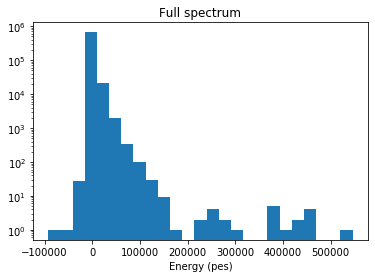

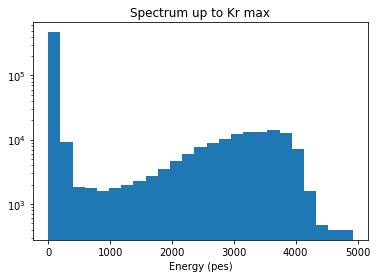

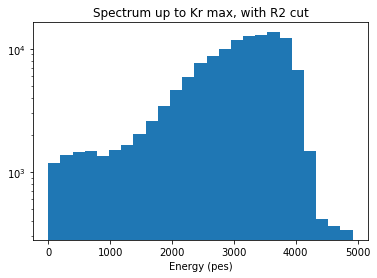

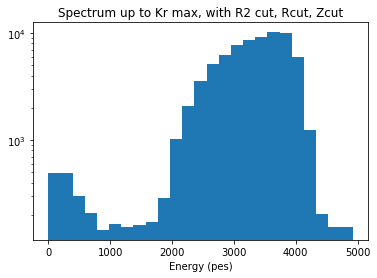

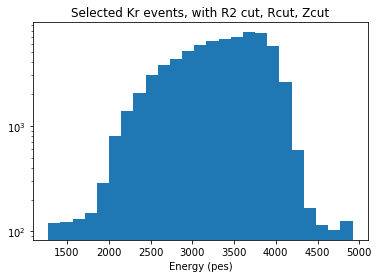

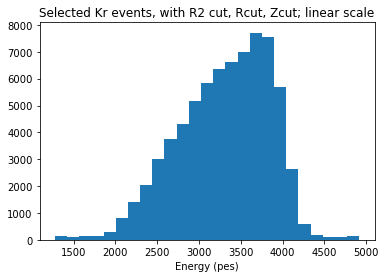

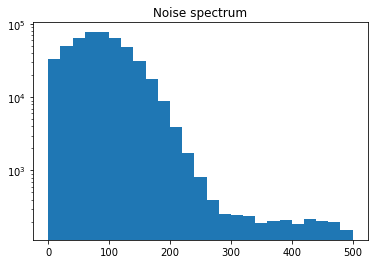

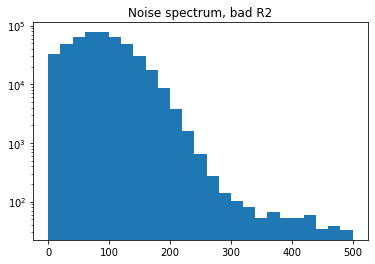

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


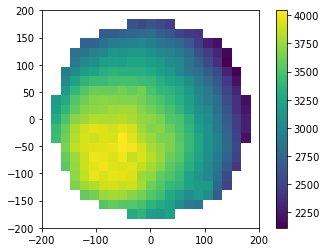

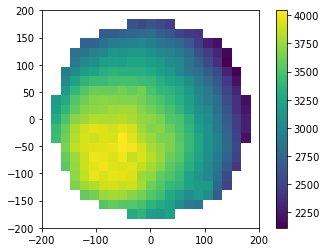

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 8.8
200000 / 582890
Est remaining = 6.1
300000 / 582890
Est remaining = 4.4
400000 / 582890
Est remaining = 2.8
500000 / 582890
Est remaining = 1.3


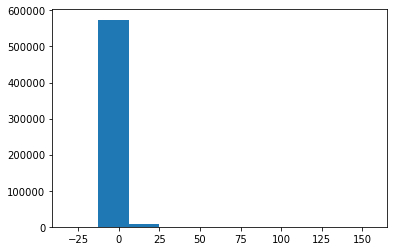

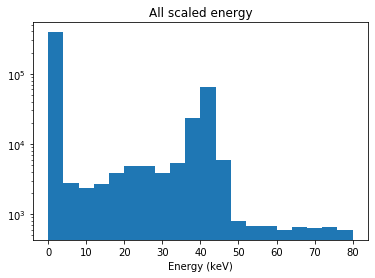

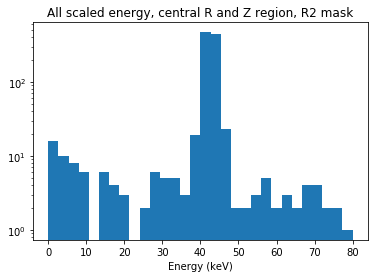

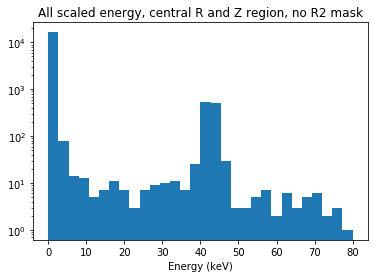

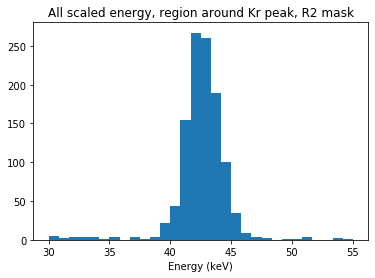

Correcting energies...
0 / 71852


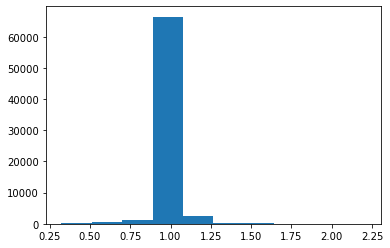

Fit a Gaussian with guess (A0, m0, s0) = (134.0, 1, 0.08162230579074516)


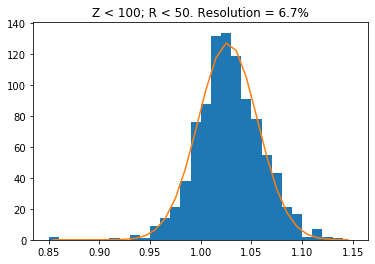

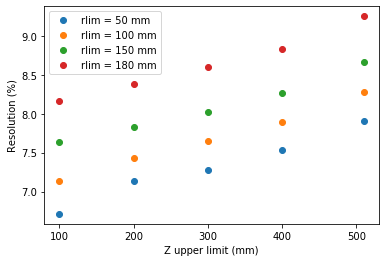

Innermost resolution =  6.71 %
Outermost resolution =  9.25 %
All resolutions: {100050: 6.712060616466285, 100100: 7.135395334899391, 100150: 7.635704484213966, 100180: 8.165986793754298, 200050: 7.131250677318969, 200100: 7.4283224054244545, 200150: 7.82286718899073, 200180: 8.379000767913237, 300050: 7.271175066188558, 300100: 7.652071680865256, 300150: 8.024082681054937, 300180: 8.60509273395422, 400050: 7.53560227358783, 400100: 7.897687341246684, 400150: 8.265075857921383, 400180: 8.83541947109431, 510050: 7.903640396099659, 510100: 8.280439219483178, 510150: 8.66525946370172, 510180: 9.251498599632836}
Peak range = 1273.2 , 4919.1
Selected percentage = 10.5 \%


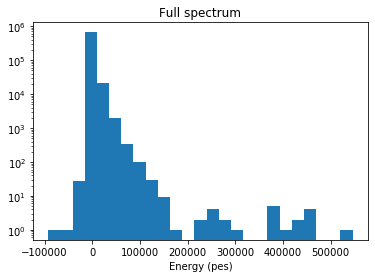

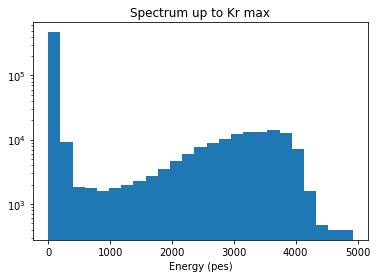

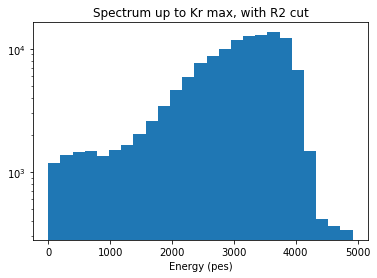

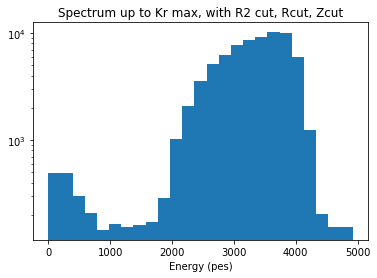

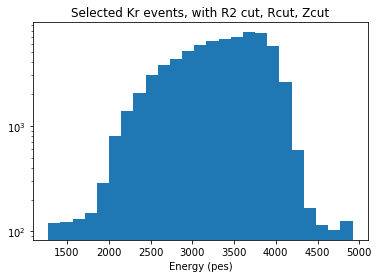

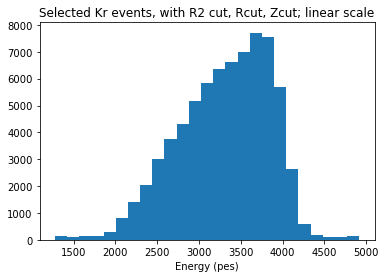

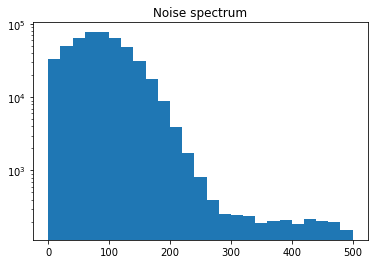

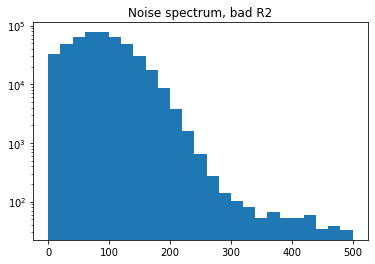

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


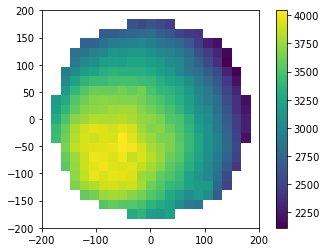

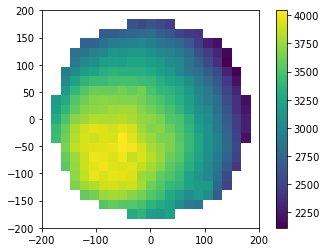

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 7.2
200000 / 582890
Est remaining = 5.9
300000 / 582890
Est remaining = 4.2
400000 / 582890
Est remaining = 2.6
500000 / 582890
Est remaining = 1.2


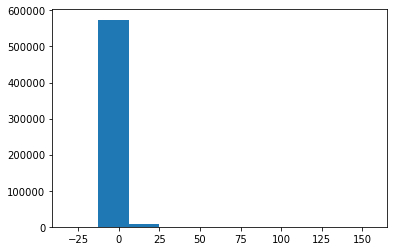

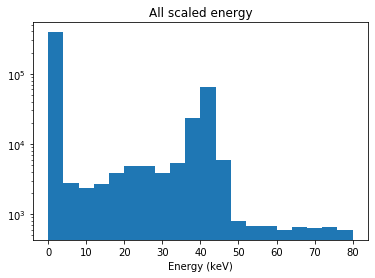

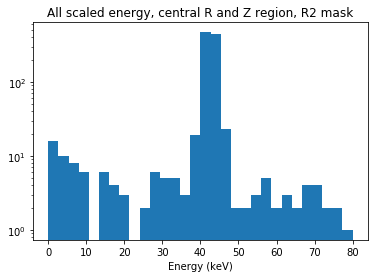

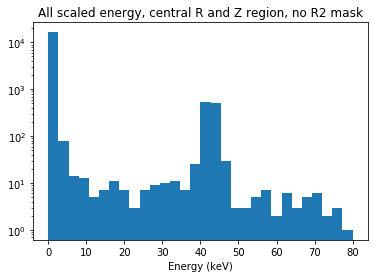

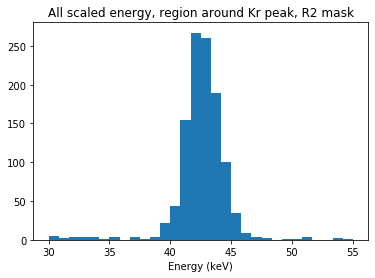

Correcting energies...
0 / 71852


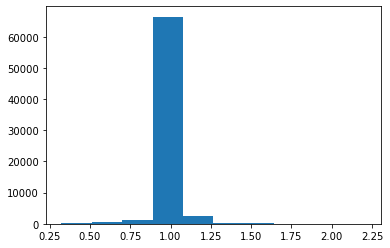

Fit a Gaussian with guess (A0, m0, s0) = (134.0, 1, 0.08162230579074516)


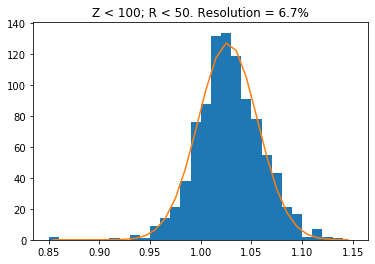

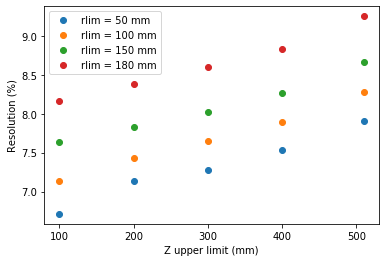

Innermost resolution =  6.71 %
Outermost resolution =  9.25 %
All resolutions: {100050: 6.712060616466285, 100100: 7.135395334899391, 100150: 7.635704484213966, 100180: 8.165986793754298, 200050: 7.131250677318969, 200100: 7.4283224054244545, 200150: 7.82286718899073, 200180: 8.379000767913237, 300050: 7.271175066188558, 300100: 7.652071680865256, 300150: 8.024082681054937, 300180: 8.60509273395422, 400050: 7.53560227358783, 400100: 7.897687341246684, 400150: 8.265075857921383, 400180: 8.83541947109431, 510050: 7.903640396099659, 510100: 8.280439219483178, 510150: 8.66525946370172, 510180: 9.251498599632836}


In [21]:
try:
    pre_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    post_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_post, 0.9)
    avg_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_avg, 0.9)
except:
    pass

In [22]:
try:
    print('Inner res for pre, post, avg:')
    print(round(list(pre_res.values())[0], 2), ',', round(list(post_res.values())[0], 2), ',', round(list(avg_res.values())[0], 2))
    print('Outer res for pre, post, avg:')
    print(round(list(pre_res.values())[-1], 2), ',', round(list(post_res.values())[-1], 2), ',', round(list(avg_res.values())[-1], 2))
except:
    pass

Inner res for pre, post, avg:
7.05 , 6.71 , 6.71
Outer res for pre, post, avg:
9.71 , 9.25 , 9.25


Peak range = 1259.5 , 4881.2
Selected percentage = 10.5 \%


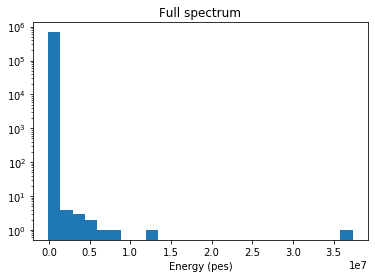

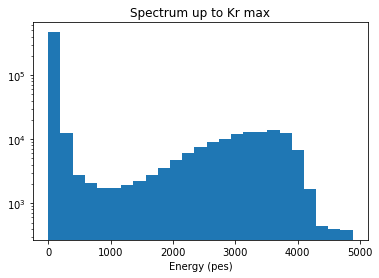

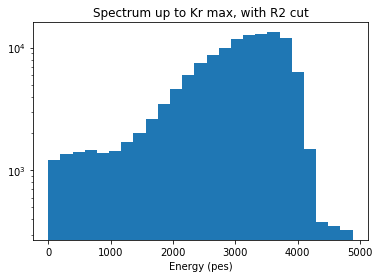

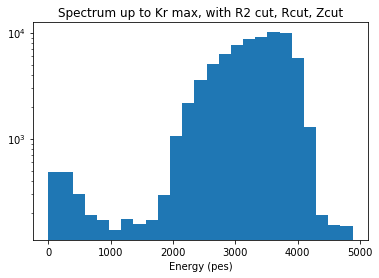

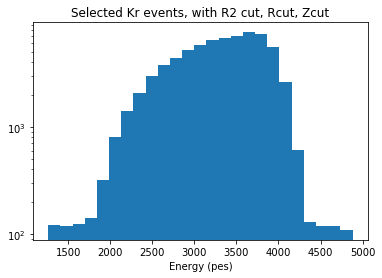

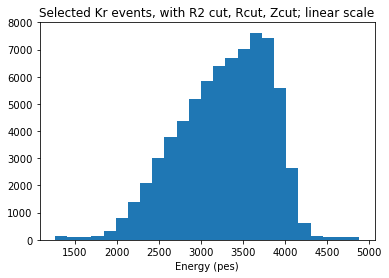

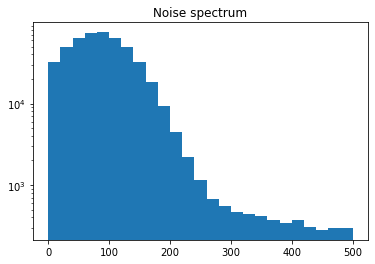

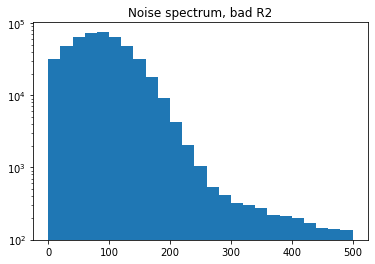

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


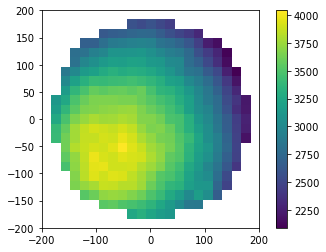

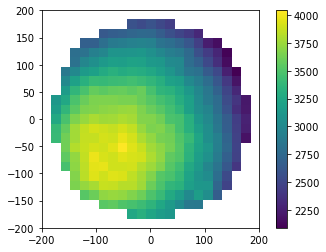

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 7.4
200000 / 582890
Est remaining = 5.8
300000 / 582890
Est remaining = 4.2
400000 / 582890
Est remaining = 2.7
500000 / 582890
Est remaining = 1.3


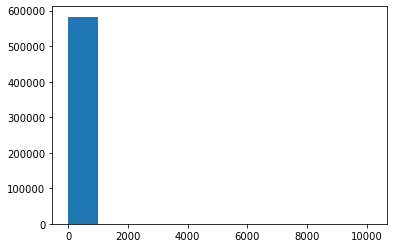

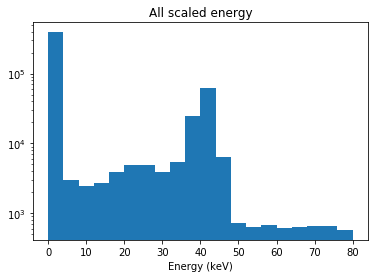

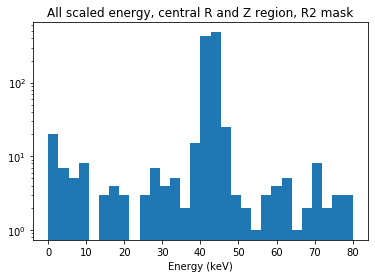

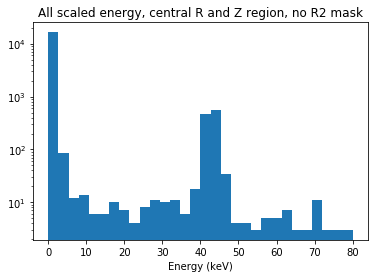

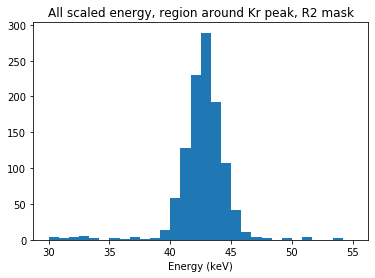

Correcting energies...
0 / 71719


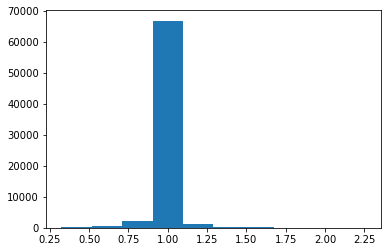

Fit a Gaussian with guess (A0, m0, s0) = (126.0, 1, 0.07763137253848336)


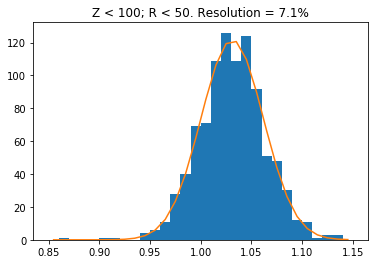

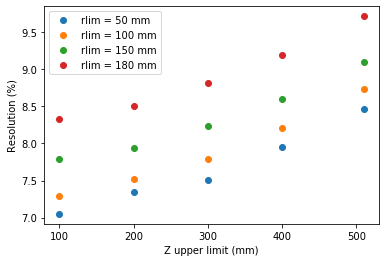

Innermost resolution =  7.05 %
Outermost resolution =  9.71 %
All resolutions: {100050: 7.050307828719949, 100100: 7.287934441866619, 100150: 7.782957104592757, 100180: 8.33117225928825, 200050: 7.345141967974677, 200100: 7.520817483825194, 200150: 7.937049326465366, 200180: 8.507043333892572, 300050: 7.508753848325098, 300100: 7.793408934352116, 300150: 8.237972285939595, 300180: 8.817073282397205, 400050: 7.9449134636249275, 400100: 8.2010989112372, 400150: 8.597307688779898, 400180: 9.195465226275035, 510050: 8.457317618372066, 510100: 8.731679278689814, 510150: 9.094446521204775, 510180: 9.710628369444054}
Peak range = 1288.8 , 4871.3
Selected percentage = 10.2 \%


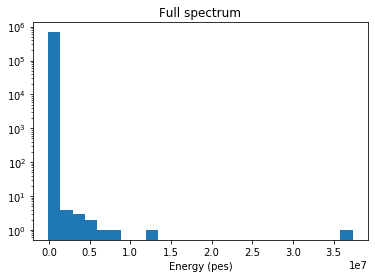

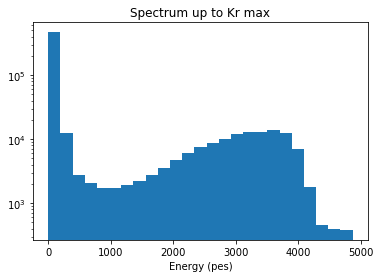

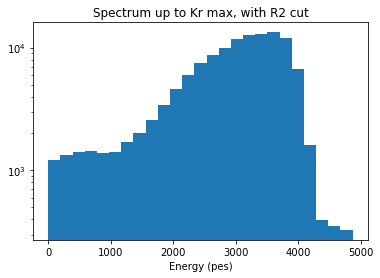

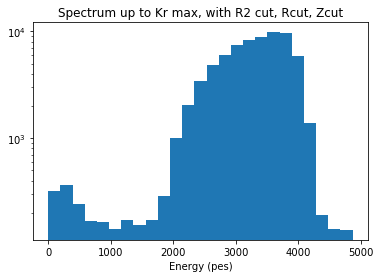

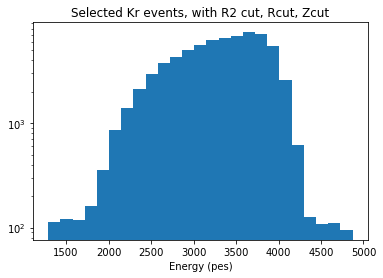

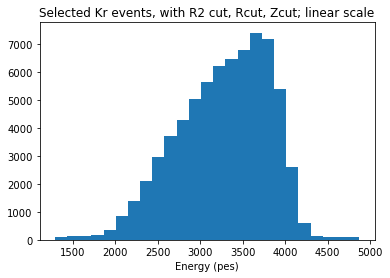

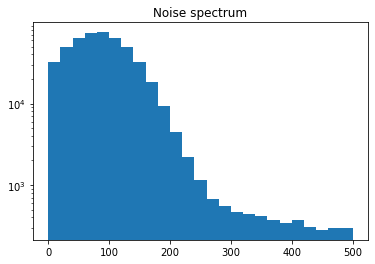

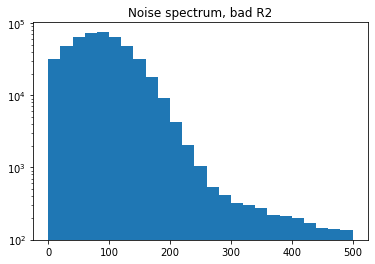

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


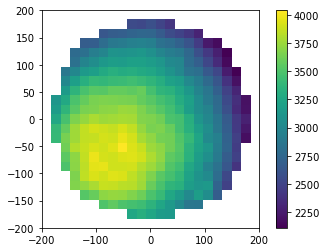

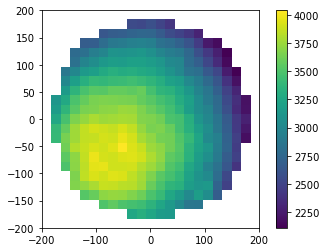

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 8.5
200000 / 582890
Est remaining = 6.5
300000 / 582890
Est remaining = 4.9
400000 / 582890
Est remaining = 3.4
500000 / 582890
Est remaining = 1.5


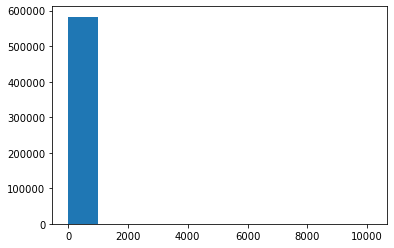

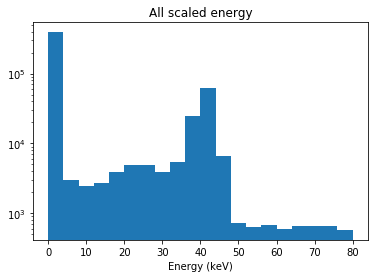

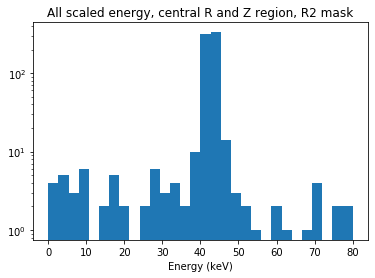

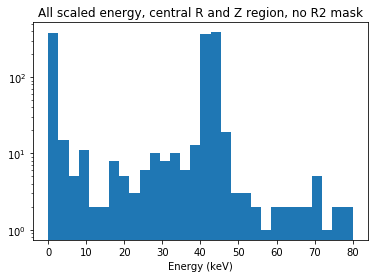

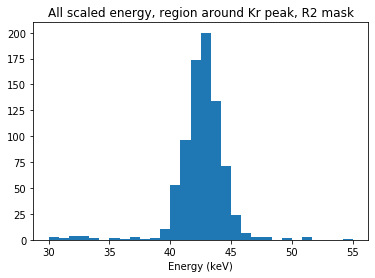

Correcting energies...
0 / 70012


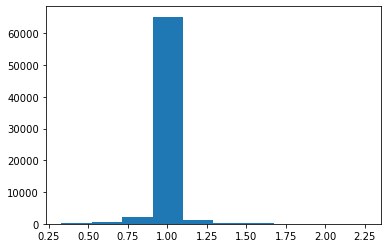

Fit a Gaussian with guess (A0, m0, s0) = (86.0, 1, 0.08324626219080872)


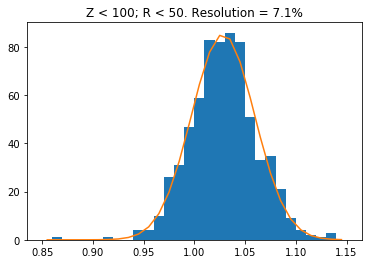

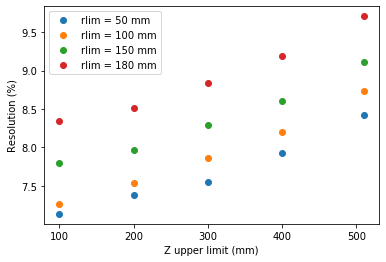

Innermost resolution =  7.13 %
Outermost resolution =  9.71 %
All resolutions: {100050: 7.1349964807142, 100100: 7.270220645429242, 100150: 7.801480481180373, 100180: 8.348098736884854, 200050: 7.3783252039685046, 200100: 7.543398817147504, 200150: 7.962386762218732, 200180: 8.51111449521695, 300050: 7.555264954014796, 300100: 7.857134701809673, 300150: 8.287428457993999, 300180: 8.841061497078881, 400050: 7.924362093712003, 400100: 8.200252198221836, 400150: 8.604855508290361, 400180: 9.186755972462477, 510050: 8.417188241522737, 510100: 8.734969792320305, 510150: 9.109094638677087, 510180: 9.706818292378124}


In [23]:
try:
    res_gauss = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    res_rms = check_resolution(histat_Zrms, histat_events_energy_subtracted_pre, 0.9)
except:
    pass

In [24]:
try:
    print('Inner res for rms, gauss:')
    print(round(list(res_rms.values())[0], 2), ',', round(list(res_gauss.values())[0], 2))
    print('Outer res for rms, gauss:')
    print(round(list(res_rms.values())[-1], 2), ',', round(list(res_gauss.values())[-1], 2))
except:
    pass

Inner res for rms, gauss:
7.13 , 7.05
Outer res for rms, gauss:
9.71 , 9.71


Peak range = 1259.5 , 4881.2
Selected percentage = 10.5 \%


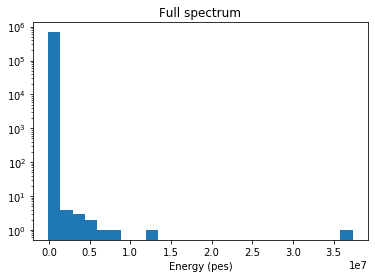

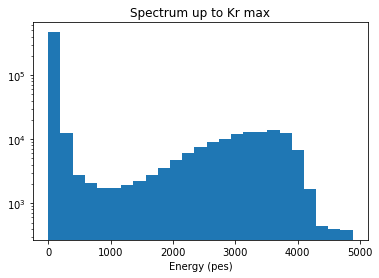

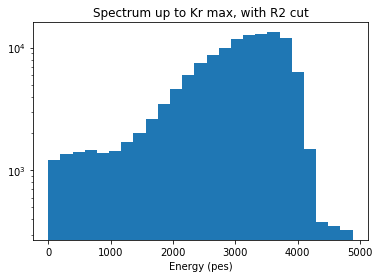

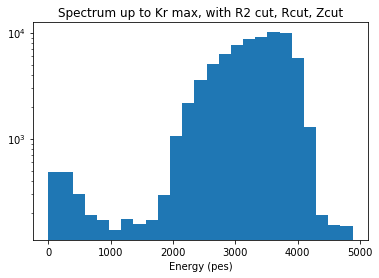

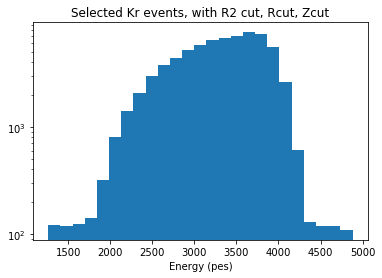

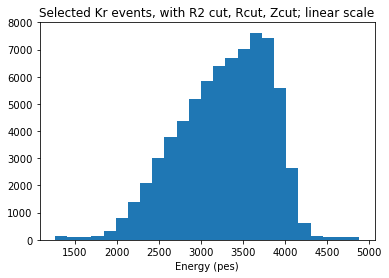

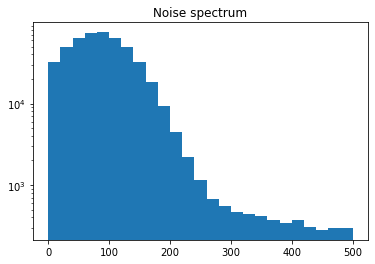

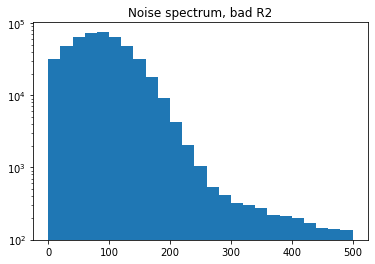

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


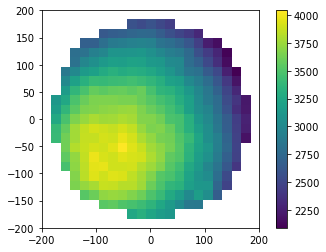

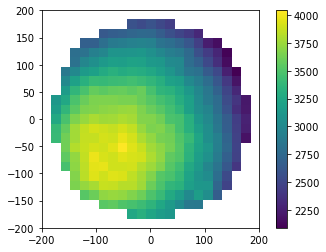

Correcting energies...
0 / 582890
100000 / 582890
Est remaining = 6.6
200000 / 582890
Est remaining = 5.5
300000 / 582890
Est remaining = 4.0
400000 / 582890
Est remaining = 2.6
500000 / 582890
Est remaining = 1.1


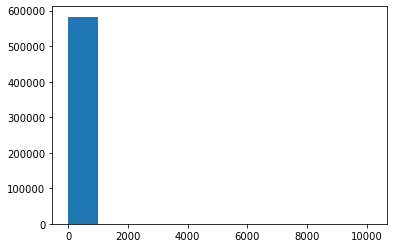

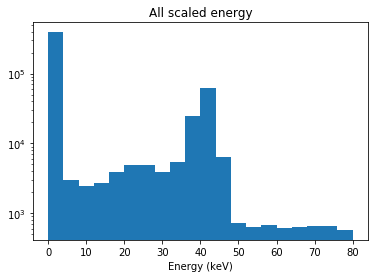

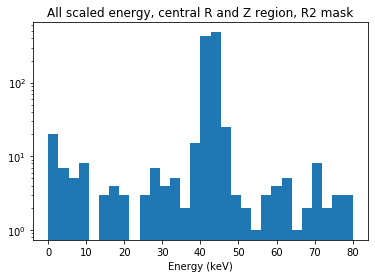

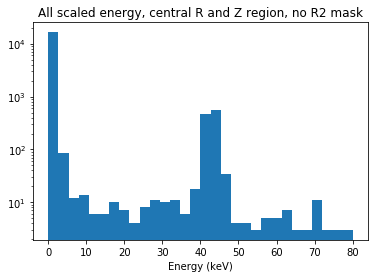

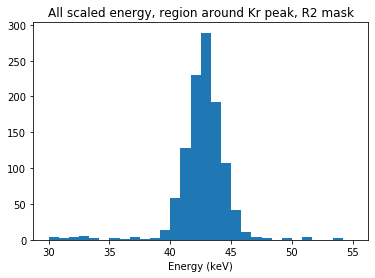

Correcting energies...
0 / 71719


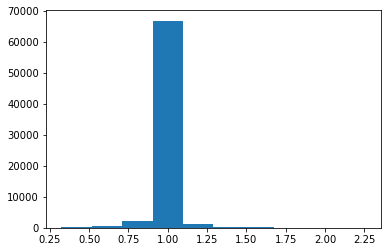

Fit a Gaussian with guess (A0, m0, s0) = (126.0, 1, 0.07763137253848336)


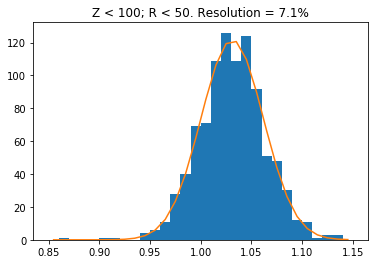

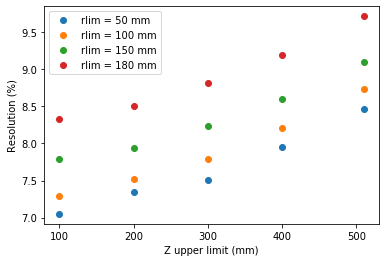

Innermost resolution =  7.05 %
Outermost resolution =  9.71 %
All resolutions: {100050: 7.050307828719949, 100100: 7.287934441866619, 100150: 7.782957104592757, 100180: 8.33117225928825, 200050: 7.345141967974677, 200100: 7.520817483825194, 200150: 7.937049326465366, 200180: 8.507043333892572, 300050: 7.508753848325098, 300100: 7.793408934352116, 300150: 8.237972285939595, 300180: 8.817073282397205, 400050: 7.9449134636249275, 400100: 8.2010989112372, 400150: 8.597307688779898, 400180: 9.195465226275035, 510050: 8.457317618372066, 510100: 8.731679278689814, 510150: 9.094446521204775, 510180: 9.710628369444054}


{100050: 7.050307828719949,
 100100: 7.287934441866619,
 100150: 7.782957104592757,
 100180: 8.33117225928825,
 200050: 7.345141967974677,
 200100: 7.520817483825194,
 200150: 7.937049326465366,
 200180: 8.507043333892572,
 300050: 7.508753848325098,
 300100: 7.793408934352116,
 300150: 8.237972285939595,
 300180: 8.817073282397205,
 400050: 7.9449134636249275,
 400100: 8.2010989112372,
 400150: 8.597307688779898,
 400180: 9.195465226275035,
 510050: 8.457317618372066,
 510100: 8.731679278689814,
 510150: 9.094446521204775,
 510180: 9.710628369444054}

In [25]:
# Output the proper map
check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)

In [26]:
print('Total time =',  round((time() - t0)/60,1), 'minutes')

Total time = 18.2 minutes
